# Figures for Greene & Salesky 2023 JFM Submission

Contains code from:

    plot_mean.ipynb
    plot_spec.ipynb
    plot_quadrant.ipynb
    plot_inst_fields.ipynb

## Import packages and set plotting params

In [1]:
%matplotlib inline
# import functions from python directory
import sys
sys.path.append("/home/bgreene/LES-utils/")
import os
import seaborn
import cmocean
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MultipleLocator
from matplotlib.gridspec import GridSpec
from matplotlib.colors import Normalize
from matplotlib.colorbar import ColorbarBase
from scipy.stats import gmean
from LESutils import load_stats, load_full, load_timeseries, read_f90_bin

In [2]:
# plotting setup
rc("font",weight="normal",size=20,family="serif",serif="Times New Roman")
rc("text",usetex="True")
props=dict(boxstyle="square",facecolor="white",edgecolor="white",alpha=0.0)

## Load data

In [3]:
# directories
# figure save
savefigs = True
fdir_save = "/home/bgreene/SBL_LES/figures/LSM/final/"
# make directory if not exist yet
if not os.path.exists(fdir_save):
    os.mkdir(fdir_save)
# list of simulations to loop over
sims = ["cr0.10", "cr0.25", "cr0.33", "cr0.50", "cr1.00"]
# empty list to construct paths and store
dnc_all = [] # directory paths
sall = []    # stats files
Eall = []    # spectrograms
Gall = []    # linear coherence spectra
Rall = []    # amplitude modulation coefficients
quadall = [] # quadrant fractions
condall = [] # conditionally averaged fields
pall = []    # joint PDFs
# simulation labels
slab = list("ABCDE")
# stats file name
fstat = "mean_stats_xyt_8-9h.nc"
# loop over sims and load stats data
for ii, sim in enumerate(sims):
    dnc = f"/home/bgreene/simulations/SBL_JFM/{sim}_192_384/"
    dnc_all.append(dnc)
    # load stats file
    s = load_stats(dnc+fstat)
    s.attrs["lab"] = slab[ii]
    sall.append(s)
    # load spectrogram file
    E = xr.load_dataset(dnc+"spectrogram_rot.nc")
    Eall.append(E)
    # # load LCS file
    g = xr.load_dataset(dnc+"G2_rot.nc")
    Gall.append(g)
    # load amplitude modulation coefficients
    r = xr.load_dataset(dnc+"AM_coefficients_zh0.25.nc")
    Rall.append(r)
    # load quadrant files
    quad = xr.load_dataset(dnc+"uw_tw_quadrant.nc")
    quadall.append(quad)
    # load conditional average files
    cond = xr.load_dataset(dnc+"cond_avg_u_lo.nc")
    condall.append(cond)
    # load joint PDFs
    p = xr.load_dataset(dnc+"u_w_theta_pdf.nc")
    pall.append(p)

# define colormap based on number of simulations
nsim = len(sims)
# seaborn palette
cmap = seaborn.cubehelix_palette(n_colors=nsim, start=0, rot=-1, gamma=1, hue=1, 
                                 light=0.8, dark=0.1, reverse=True)
cmap2 = cmocean.cm.balance
cmap3 = seaborn.color_palette("cubehelix_r", as_cmap=True)
cmap3_r = seaborn.color_palette("cubehelix", as_cmap=True)
# custom linestyles
dash = [(1,()),
        (0, (5, 1)),
        (0, (1, 1)),
        (0, (3, 1, 1, 1)),
        (0, (3, 1, 1, 1, 1, 1)),
        (0, (3, 1, 3, 1, 1, 1, 1, 1)),
        (0, (3, 1, 1, 1)),
        (0, (3, 1)),
        (1, ())]

Reading file: /home/bgreene/simulations/SBL_JFM/cr0.10_192_384/mean_stats_xyt_8-9h.nc
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.25_192_384/mean_stats_xyt_8-9h.nc
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.33_192_384/mean_stats_xyt_8-9h.nc
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.50_192_384/mean_stats_xyt_8-9h.nc
Reading file: /home/bgreene/simulations/SBL_JFM/cr1.00_192_384/mean_stats_xyt_8-9h.nc


In [ ]:
# print some statistics
for s in sall:
    print(f"---{s.lab}---")
    print(f"h = {s.h.values}")
    print(f"zj = {s.zj.values}")
    print(f"zj/h = {(s.zj/s.h).values}")
    print(f"ustar0 = {s.ustar0.values}")
    print(f"tstar0 = {s.tstar0.values}")
    print(f"L = {s.L.values}")
    print(f"h/L = {(s.h/s.L).values}")
    jz = np.where(s.z >= s.h)[0][0]
    dudz = (s.u_mean[jz] - s.u_mean[0]) / s.h
    dvdz = (s.v_mean[jz] - s.v_mean[0]) / s.h
    S2 = (dudz**2.) + (dvdz**2.)
    dTdz = (s.theta_mean[jz] - s.theta_mean[0]) /s.h
    N2 = dTdz * 9.81 / s.theta_mean[0]
    RiB = N2 / S2
    print(f"RiB = {RiB.values}")
    print(f"dTdz = {dTdz.values * 1000}")
    TL = s.h / s.ustar0
    print(f"TL = {TL.values}")
    nTL = 3600. / TL.values
    print(f"nTL = {nTL}")

## Figure 1: Ozmidov scale

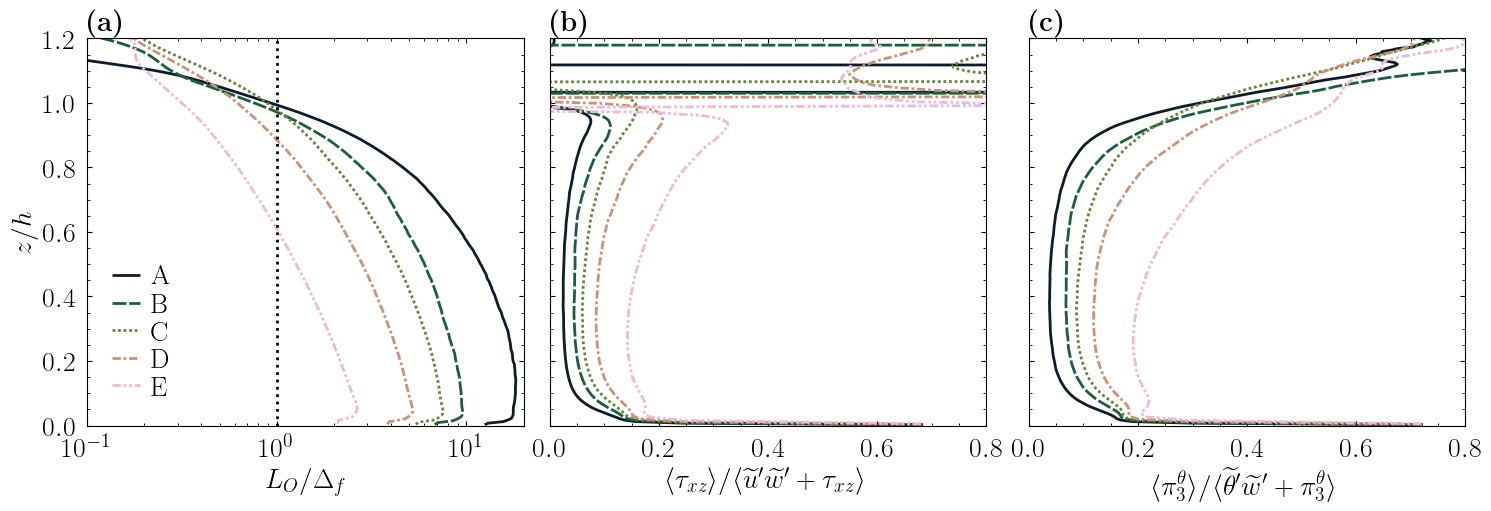

In [40]:
fig1, ax1 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14.8, 5), constrained_layout=True)
# loop over sims
for ii, s in enumerate(sall):
    # zi = s.z.where(s.uh >= 1.05*8., drop=True)[-1].values
    # zi = s.uw_cov_tot.argmax()
    # zi = s.z.where(s.ustar2 <= 0.01*s.ustar2[0], drop=True)[0].values / 0.99
    # dG = s.uh.max() - 8.
    # zi = s.z.where(s.uh >= 8 + 0.5*dG, drop=True)[-1].values
    # s["h"] = zi
    # Lo
    ax1[0].plot(s.Lo/s.delta, s.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # SGS ratios
    # u'w'
    # NOTE: check this math
    txz = s.uw_cov_tot - s.uw_cov_res
    tyz = s.vw_cov_tot - s.vw_cov_res
    ustar2_sgs = np.sqrt(txz**2 + tyz**2)
    ax1[1].plot(txz/s.uw_cov_tot, s.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # theta'w'
    q3 = s.tw_cov_tot - s.tw_cov_res
    ax1[2].plot(q3/s.tw_cov_tot, s.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
# vertical line in panel a for filter width
# ax1[0].axvline(s.delta, c="k", lw=2, ls=":", label="$\\Delta_f$")
# ax1[0].axvline(s.dz, c="k", lw=2, ls="--", label="$\\Delta_z$")
ax1[0].axvline(1, c="k", lw=2, ls=":")
# legend
ax1[0].legend(frameon=False, labelspacing=0.10, #ncol=5, columnspacing=1,
              handletextpad=0.4, handlelength=1, loc="lower left")
# axis limits
ax1[0].set_ylim([0, 1.2])
ax1[0].set_xlim([0.1, 20])
ax1[0].set_xscale("log")
ax1[1].set_xlim([0, 0.8])
ax1[2].set_xlim([0, 0.8])
# axis ticks
ax1[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax1[0].yaxis.set_minor_locator(MultipleLocator(0.05))
# ax1[0].xaxis.set_major_locator(MultipleLocator(5))
# ax1[0].xaxis.set_minor_locator(MultipleLocator(1))
ax1[1].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[1].xaxis.set_minor_locator(MultipleLocator(0.05))
ax1[2].xaxis.set_major_locator(MultipleLocator(0.2))
ax1[2].xaxis.set_minor_locator(MultipleLocator(0.05))
# axis labels
ax1[0].set_ylabel("$z/h$")
ax1[0].set_xlabel(r"$L_O/\Delta_f$")
ax1[1].set_xlabel(r"$\langle \tau_{xz} \rangle / \langle \widetilde{u}'\widetilde{w}' + \tau_{xz} \rangle$")
ax1[2].set_xlabel(r"$\langle \pi_3^{\theta} \rangle / \langle \widetilde{\theta}'\widetilde{w}' + \pi_3^{\theta} \rangle$")
# tick lines inside plot
for iax, lab in zip(ax1, list("abc")):
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
    # iax.text(0.88,0.90,f"$\\textbf{{({lab})}}$",fontsize=20,
    #          transform=iax.transAxes)
    iax.set_title(rf"\textbf{{({lab})}}", loc="left", fontsize=20)
# save
if savefigs:
    fig1.savefig(f"{fdir_save}Fig01.pdf", format="pdf")

## Figure 2: Mean profiles

In [11]:
# (a)wspd; (b) <\Theta>; (c) urms;
# (d) ustar^2; (e) <\theta'w'>; (f) Ri_g
fig2, ax2 = plt.subplots(nrows=2, ncols=3, sharey=True, 
                         figsize=(14.8, 10), constrained_layout=True)
for i, s in enumerate(sall):
    # zi = s.z.where(s.uh >= 1.05*8., drop=True)[-1].values
    # zi = s.z.where(s.ustar2 <= 0.25*s.ustar2[0], drop=True)[0].values / 0.75
    dG = s.uh.max() - 8.
    # zi = s.z.where(s.uh >= 8 + 0.5*dG, drop=True)[-1].values
    zi = s.h
    # now plot
    # row 1
    # (a) Uh
    # ax2[0,0].plot(s.uh, s.z/zi, ls=dash[i], c=cmap[i], lw=2, label=s.lab)
    ax2[0,0].plot(s.uh/8., s.z/zi, ls=dash[i], c=cmap[i], lw=2, label=s.lab)
    # (b) <\theta>
    # ax2[0,1].plot(s.theta_mean, s.z/zi, ls=dash[i], c=cmap[i], lw=2, label=s.lab)
    ax2[0,1].plot((s.theta_mean-s.theta_mean[0])/s.tstar0, s.z/zi, ls=dash[i], c=cmap[i], lw=2, label=s.lab)
    # (c) rms velocity
    ax2[0,2].plot(np.sqrt(s.e)/s.ustar0, s.z/zi, ls=dash[i], c=cmap[i], lw=2, label=s.lab)
    # row 2
    # (d) ustar^2
    ax2[1,0].plot(s.ustar2/s.ustar0/s.ustar0, s.z/zi, ls=dash[i], c=cmap[i], lw=2)
    # (e) <\theta'w'>
    ax2[1,1].plot(s.tw_cov_tot/s.ustar0/s.tstar0, s.z/zi, ls=dash[i], c=cmap[i], lw=2)
    # (f) Rig
    ax2[1,2].plot(s.Rig, s.z/zi, ls=dash[i], c=cmap[i], lw=2)
# clean up
# (a)
# ax2[0,0].set_xlabel("$U_h$ [m s$^{-1}$]")
ax2[0,0].set_xlabel("$U_h / G$")
ax2[0,0].set_ylabel("$z/h$")
ax2[0,0].set_xlim([0, 1.4])
ax2[0,0].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[0,0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[0,0].set_ylim([0, 1.2])
ax2[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax2[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax2[0,0].text(0.87,0.05,r'\textbf{(a)}',fontsize=20,bbox=props, 
              transform=ax2[0,0].transAxes)
ax2[0,0].legend(frameon=False, labelspacing=0.10, ncol=1, columnspacing=1,
                handletextpad=0.4, handlelength=1, loc="upper left")
# (b)
# ax2[0,1].set_xlabel("$\\Theta$ [K]")
ax2[0,1].set_xlabel(r"$(\Theta - \Theta_0)/\theta_{\tau0}$")
# ax2[0,1].set_xlim([256, 266.])
ax2[0,1].set_xlim([0, 60])
ax2[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax2[0,1].xaxis.set_minor_locator(MultipleLocator(2))
ax2[0,1].text(0.87,0.05,r'\textbf{(b)}',fontsize=20,bbox=props, 
              transform=ax2[0,1].transAxes)
# (c)
ax2[0,2].set_xlabel(r"$u_{rms} / u_{\tau 0}$")
ax2[0,2].set_xlim([0, 2.5])
ax2[0,2].xaxis.set_major_locator(MultipleLocator(0.5))
ax2[0,2].xaxis.set_minor_locator(MultipleLocator(0.1))
ax2[0,2].text(0.03,0.05,r'\textbf{(c)}',fontsize=20,bbox=props, 
              transform=ax2[0,2].transAxes)
# (d)
ax2[1,0].set_xlabel(r"$u_{\tau}^2 / u_{\tau 0}^2$")
ax2[1,0].set_ylabel("$z/h$")
ax2[1,0].set_xlim([0, 1.15])
ax2[1,0].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[1,0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[1,0].text(0.03,0.05,r'\textbf{(d)}',fontsize=20,bbox=props, 
              transform=ax2[1,0].transAxes)
# (e)
ax2[1,1].set_xlabel(r"$\langle \widetilde{\theta}'\widetilde{w}' + \pi_3^{\theta} \rangle / \theta_{\tau 0} u_{\tau 0}$")
ax2[1,1].set_xlim([-1.15, 0])
ax2[1,1].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[1,1].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[1,1].text(0.87,0.05,r'\textbf{(e)}',fontsize=20,bbox=props, 
              transform=ax2[1,1].transAxes)
# (f)
# vertical line
ax2[1,2].axvline(0.2, lw=1, c="k")
ax2[1,2].set_xlabel("$Ri_g$")
# ax2[1,2].set_xscale("log")
ax2[1,2].set_xlim([0, 0.35])
ax2[1,2].xaxis.set_major_locator(MultipleLocator(0.1))
ax2[1,2].xaxis.set_minor_locator(MultipleLocator(0.025))
ax2[1,2].text(0.87,0.05,r'\textbf{(f)}',fontsize=20,bbox=props, 
              transform=ax2[1,2].transAxes)
# tick lines inside plot
for iax in ax2.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save
if savefigs:
    fig2.savefig(f"{fdir_save}Fig02.pdf", format="pdf")

## Figure 3: Instantaneous fields

Row 1: $u'(x,y;z/h=0.1)$

Row 2: $\theta'(x,y;z/h=0.1)$

Row 3: $u'(x,z;y=L_y/2)$

Col 1: Case A

Col 2: Case E

In [9]:
# load these cases
tt = 1440000
dd1, s1 = load_full(dnc_all[0], tt, tt, 1000, 0.02, fstat, False)
dd2, s2 = load_full(dnc_all[2], tt, tt, 1000, 0.02, fstat, False)
dd3, s3 = load_full(dnc_all[4], tt, tt, 1000, 0.02, fstat, False)
# also load rotated ones for cross-sections
dd1r = load_full(dnc_all[0], tt, tt, 1000, 0.02, None, True)
dd2r = load_full(dnc_all[2], tt, tt, 1000, 0.02, None, True)
dd3r = load_full(dnc_all[4], tt, tt, 1000, 0.02, None, True)
# grab coordinates
xh1 = dd1.x/s1.h
yh1 = dd1.y/s1.h
zh1 = dd1.z/s1.h
xh2 = dd2.x/s2.h
yh2 = dd2.y/s2.h
zh2 = dd2.z/s2.h
xh3 = dd3.x/s3.h
yh3 = dd3.y/s3.h
zh3 = dd3.z/s3.h
# calculate parameters to be plotted
# u'
up1 = (dd1.u_rot - dd1.u_rot.mean(dim=("x","y"))).isel(time=0)/s1.ustar0
up2 = (dd2.u_rot - dd2.u_rot.mean(dim=("x","y"))).isel(time=0)/s2.ustar0
up3 = (dd3.u_rot - dd3.u_rot.mean(dim=("x","y"))).isel(time=0)/s3.ustar0
# u' rot
up1r = (dd1r.u_rot - dd1r.u_rot.mean(dim=("x","y"))).isel(time=0)/s1.ustar0
up2r = (dd2r.u_rot - dd2r.u_rot.mean(dim=("x","y"))).isel(time=0)/s2.ustar0
up3r = (dd3r.u_rot - dd3r.u_rot.mean(dim=("x","y"))).isel(time=0)/s3.ustar0
# theta'
Tp1 = (dd1.theta - dd1.theta.mean(dim=("x","y"))).isel(time=0)/s1.tstar0
Tp2 = (dd2.theta - dd2.theta.mean(dim=("x","y"))).isel(time=0)/s2.tstar0
Tp3 = (dd3.theta - dd3.theta.mean(dim=("x","y"))).isel(time=0)/s3.tstar0
# theta' rot
Tp1r = (dd1r.theta - dd1r.theta.mean(dim=("x","y"))).isel(time=0)/s1.tstar0
Tp2r = (dd2r.theta - dd2r.theta.mean(dim=("x","y"))).isel(time=0)/s2.tstar0
Tp3r = (dd3r.theta - dd3r.theta.mean(dim=("x","y"))).isel(time=0)/s3.tstar0
# w'
wp1 = (dd1.w - dd1.w.mean(dim=("x","y"))).isel(time=0)/s1.ustar0
wp2 = (dd2.w - dd2.w.mean(dim=("x","y"))).isel(time=0)/s2.ustar0
wp3 = (dd3.w - dd3.w.mean(dim=("x","y"))).isel(time=0)/s3.ustar0
# NEW: grab x-z cross sections from rotated fields

Loading files...
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.10_192_384/mean_stats_xyt_8-9h.nc
Loading files...
Reading file: /home/bgreene/simulations/SBL_JFM/cr0.33_192_384/mean_stats_xyt_8-9h.nc
Loading files...
Reading file: /home/bgreene/simulations/SBL_JFM/cr1.00_192_384/mean_stats_xyt_8-9h.nc
Loading files...
Loading files...
Loading files...


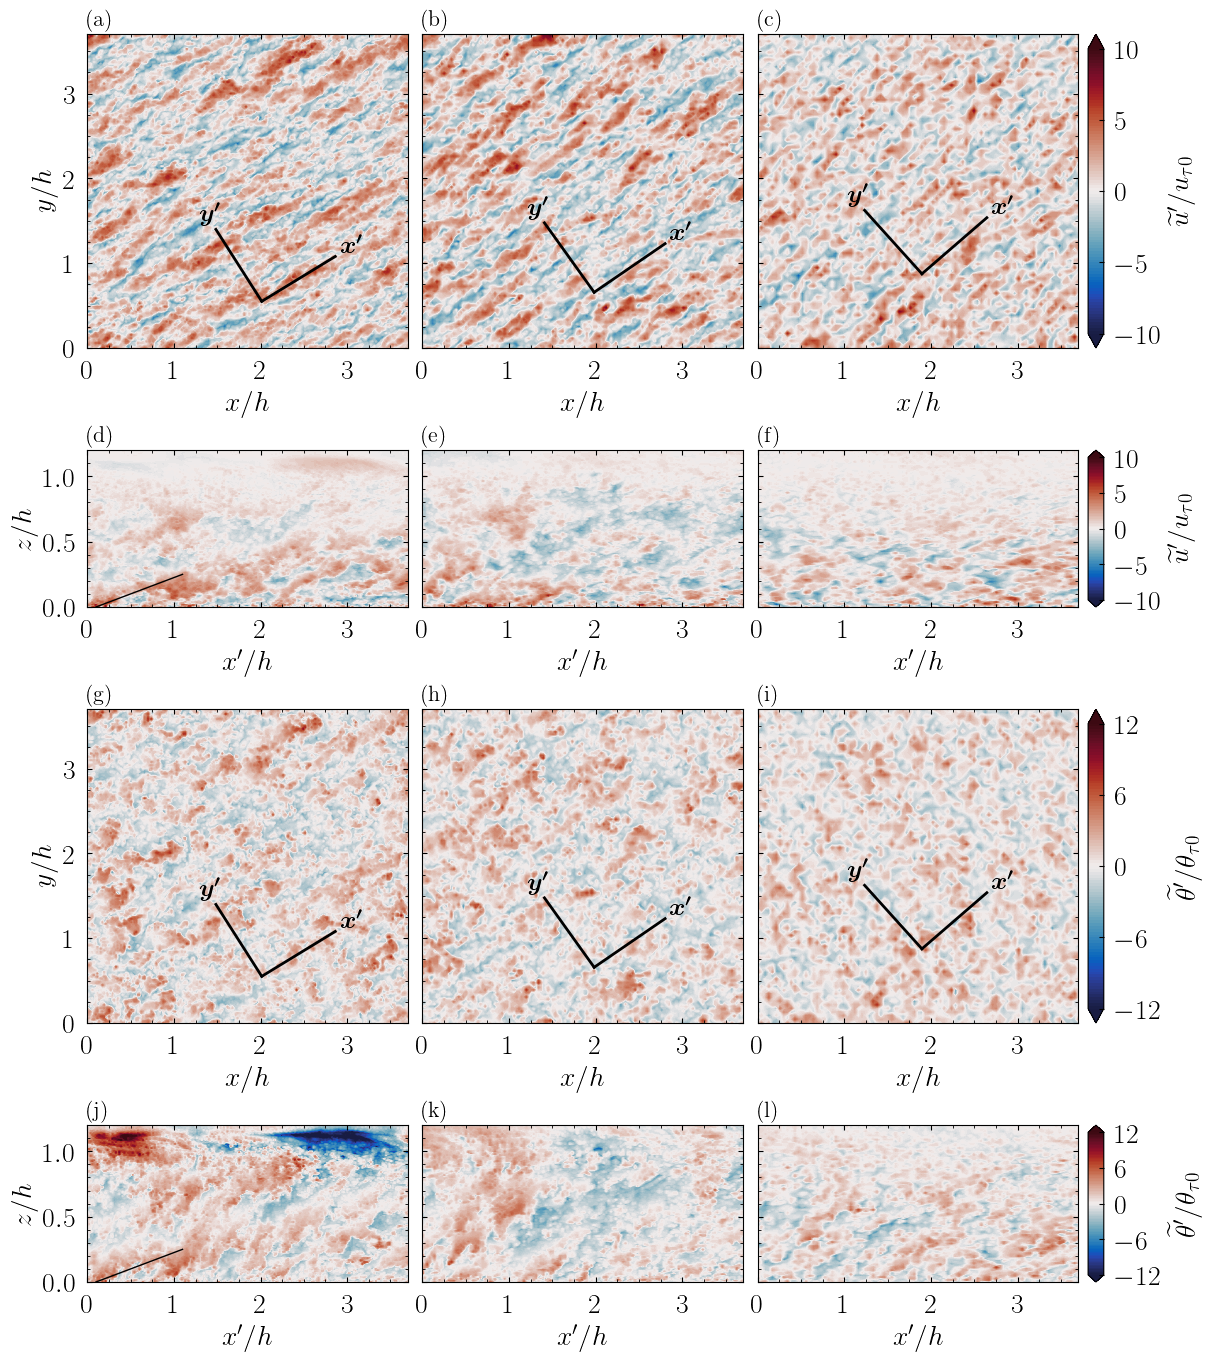

In [15]:
# calculate indices for plotting
# z/h = 0.1
jz1 = abs(zh1 - 0.05).argmin()
jz2 = abs(zh2 - 0.05).argmin()
jz3 = abs(zh3 - 0.05).argmin()
# y/h = 2
# jy1 = abs(yh1 - 2.0).argmin()
# jy2 = abs(yh2 - 2.0).argmin()
# calculate reference x' y' coordinate system to overlay
# choose constant value of y' from plotting rotated fields
# xr0 = np.array([2, 3]) # x-coords of x' axis
# yr0 = np.array([1.55, 1.55]) # y-coords of x' axis
# xr1 = np.array([2, 2]) # x-coords of y'
# yr1 = np.array([1.55, 2.55]) # y-coords of y'
xr0 = np.array([2, 3]) # x-coords of x' axis
yr0 = np.array([1, 1]) - 1.6 # y-coords of x' axis
xr1 = np.array([2, 2]) # x-coords of y'
yr1 = np.array([1, 2]) - 1.6 # y-coords of y'
# now rotate this back to lab frame
alpha1 = np.arctan2(dd1.v.isel(z=jz1, time=0).mean(dim=("x","y")),
                    dd1.u.isel(z=jz1, time=0).mean(dim=("x","y"))).values
x0 = xr0*np.cos(alpha1) - yr0*np.sin(alpha1) # x-coords of x axis
y0 = xr0*np.sin(alpha1) + yr0*np.cos(alpha1) # y-coords of x axis
x1 = xr1*np.cos(alpha1) - yr1*np.sin(alpha1) # x-coords of y axis
y1 = xr1*np.sin(alpha1) + yr1*np.cos(alpha1) # y-coords of y axis
# same thing but for second sim
alpha2 = np.arctan2(dd2.v.isel(z=jz2, time=0).mean(dim=("x","y")),
                    dd2.u.isel(z=jz2, time=0).mean(dim=("x","y"))).values
x2 = xr0*np.cos(alpha2) - yr0*np.sin(alpha2) # x-coords of x axis
y2 = xr0*np.sin(alpha2) + yr0*np.cos(alpha2) # y-coords of x axis
x3 = xr1*np.cos(alpha2) - yr1*np.sin(alpha2) # x-coords of y axis
y3 = xr1*np.sin(alpha2) + yr1*np.cos(alpha2) # y-coords of y axis
# same thing but for third sim
alpha3 = np.arctan2(dd3.v.isel(z=jz3, time=0).mean(dim=("x","y")),
                    dd3.u.isel(z=jz3, time=0).mean(dim=("x","y"))).values
x4 = xr0*np.cos(alpha3) - yr0*np.sin(alpha3) # x-coords of x axis
y4 = xr0*np.sin(alpha3) + yr0*np.cos(alpha3) # y-coords of x axis
x5 = xr1*np.cos(alpha3) - yr1*np.sin(alpha3) # x-coords of y axis
y5 = xr1*np.sin(alpha3) + yr1*np.cos(alpha3) # y-coords of y axis

# now grab new value of jy1
jy1 = abs(yh1 - yr1[0]).argmin()
jy2 = abs(yh2 - yr1[0]).argmin()
jy3 = abs(yh3 - yr1[0]).argmin()

# initialize figure
fig3 = plt.figure(constrained_layout=True, figsize=(12, 13.5))
# add gridspec
gs = GridSpec(6, 3, figure=fig3)
# define axes
# u(x,y)
ax1 = fig3.add_subplot(gs[:2, 0]) # top left
ax2 = fig3.add_subplot(gs[:2, 1], sharex=ax1, sharey=ax1) # top center
ax3 = fig3.add_subplot(gs[:2, 2], sharex=ax1, sharey=ax1) # top right
# u(x,z)
ax4 = fig3.add_subplot(gs[2, 0], sharex=ax1) # row 2 left
ax5 = fig3.add_subplot(gs[2, 1], sharex=ax1, sharey=ax4) # row 2 center
ax6 = fig3.add_subplot(gs[2, 2], sharex=ax1, sharey=ax4) # row 2 right
# theta(x,y)
ax7 = fig3.add_subplot(gs[3:5, 0], sharex=ax1, sharey=ax1) # row 3 left
ax8 = fig3.add_subplot(gs[3:5, 1], sharex=ax1, sharey=ax1) # row 3 center
ax9 = fig3.add_subplot(gs[3:5, 2], sharex=ax1, sharey=ax1) # row 3 right
# theta(x,z)
ax10 = fig3.add_subplot(gs[-1, 0], sharex=ax1, sharey=ax4) # bottom left
ax11 = fig3.add_subplot(gs[-1, 1], sharex=ax1, sharey=ax4) # bottom center
ax12 = fig3.add_subplot(gs[-1, 2], sharex=ax1, sharey=ax4) # bottom right
# define contour levels
levelu = np.linspace(-10, 10, 101)
levelT = np.linspace(-12, 12, 101)
# plot
# row 1: u', x-y
cfax1 = ax1.contourf(xh1, yh1, up1.isel(z=jz1).T, cmap=cmap2, levels=levelu, extend="both")
cfax2 = ax2.contourf(xh2, yh2, up2.isel(z=jz2).T, cmap=cmap2, levels=levelu)
cfax3 = ax3.contourf(xh3, yh3, up3.isel(z=jz3).T, cmap=cmap2, levels=levelu)
# row 2: u', x-z
cfax4 = ax4.contourf(xh1, zh1, up1r.isel(y=jy1).T, cmap=cmap2, levels=levelu, extend="both")
cfax5 = ax5.contourf(xh2, zh2, up2r.isel(y=jy2).T, cmap=cmap2, levels=levelu)
cfax6 = ax6.contourf(xh3, zh3, up3r.isel(y=jy3).T, cmap=cmap2, levels=levelu)
# row 3: T', x-y
cfax7 = ax7.contourf(xh1, yh1, Tp1.isel(z=jz1).T, cmap=cmap2, levels=levelT, extend="both")
cfax8 = ax8.contourf(xh2, yh2, Tp2.isel(z=jz2).T, cmap=cmap2, levels=levelT)
cfax9 = ax9.contourf(xh3, yh3, Tp3.isel(z=jz3).T, cmap=cmap2, levels=levelT)
# row 3: T', x-z
cfax10 = ax10.contourf(xh1, zh1, Tp1r.isel(y=jy1).T, cmap=cmap2, levels=levelT, extend="both")
cfax11 = ax11.contourf(xh2, zh2, Tp2r.isel(y=jy2).T, cmap=cmap2, levels=levelT)
cfax12 = ax12.contourf(xh3, zh3, Tp3r.isel(y=jy3).T, cmap=cmap2, levels=levelT)
# rotated axes for cross-sections
# A u
ax1.plot(x0, y0, c="k", lw=2)
ax1.plot(x1, y1, c="k", lw=2)
# A theta
ax7.plot(x0, y0, c="k", lw=2)
ax7.plot(x1, y1, c="k", lw=2)
# C u
ax2.plot(x2, y2, c="k", lw=2)
ax2.plot(x3, y3, c="k", lw=2)
# C theta
ax8.plot(x2, y2, c="k", lw=2)
ax8.plot(x3, y3, c="k", lw=2)
# E u
ax3.plot(x4, y4, c="k", lw=2)
ax3.plot(x5, y5, c="k", lw=2)
# E theta
ax9.plot(x4, y4, c="k", lw=2)
ax9.plot(x5, y5, c="k", lw=2)
# coordinate labels
ax1.text(x0[1]+0.05, y0[1]+0.05, r"\boldmath$x'$", fontsize=18)
ax1.text(x1[1]-0.20, y1[1]+0.10, r"\boldmath$y'$", fontsize=18)
ax7.text(x0[1]+0.05, y0[1]+0.05, r"\boldmath$x'$", fontsize=18)
ax7.text(x1[1]-0.20, y1[1]+0.10, r"\boldmath$y'$", fontsize=18)
ax2.text(x2[1]+0.05, y2[1]+0.05, r"\boldmath$x'$", fontsize=18)
ax2.text(x3[1]-0.20, y3[1]+0.10, r"\boldmath$y'$", fontsize=18)
ax8.text(x2[1]+0.05, y2[1]+0.05, r"\boldmath$x'$", fontsize=18)
ax8.text(x3[1]-0.20, y3[1]+0.10, r"\boldmath$y'$", fontsize=18)
ax3.text(x4[1]+0.05, y4[1]+0.05, r"\boldmath$x'$", fontsize=18)
ax3.text(x5[1]-0.20, y5[1]+0.10, r"\boldmath$y'$", fontsize=18)
ax9.text(x4[1]+0.05, y4[1]+0.05, r"\boldmath$x'$", fontsize=18)
ax9.text(x5[1]-0.20, y5[1]+0.10, r"\boldmath$y'$", fontsize=18)
# line for highlighting LSM in case A u, theta
ax4.plot([.1, 1.1], [0, 0.25], c="k", lw=1)
ax10.plot([.1, 1.1], [0, 0.25], c="k", lw=1)
# colorbars
cb123 = fig3.colorbar(cfax1, ax=[ax1, ax2, ax3], location="right", ticks=[-10, -5, 0, 5, 10],
                      pad=0.01)
cb456 = fig3.colorbar(cfax4, ax=[ax4, ax5, ax6], location="right", ticks=[-10, -5, 0, 5, 10], 
                      pad=0.01, aspect=10)
cb789 = fig3.colorbar(cfax7, ax=[ax7, ax8, ax9], location="right", ticks=[-12, -6, 0, 6, 12],
                      pad=0.01)
cb100 = fig3.colorbar(cfax10, ax=[ax10, ax11, ax12], location="right", ticks=[-12, -6, 0, 6, 12], 
                      pad=0.01, aspect=10)
# colorbar labels
cb123.ax.set_ylabel(r"$\widetilde{u}'/u_{\tau 0}$")
cb456.ax.set_ylabel(r"$\widetilde{u}'/u_{\tau 0}$")
cb789.ax.set_ylabel(r"$\widetilde{\theta}'/\theta_{\tau 0}$")
cb100.ax.set_ylabel(r"$\widetilde{\theta}'/\theta_{\tau 0}$")
# axis limits
ax1.set_xlim([0, 3.7])
ax1.set_ylim([0, 3.7])
ax4.set_ylim([0, 1.2])
# remove axis tick labels
ax1.tick_params(labelbottom=True, labelleft=True)
ax2.tick_params(labelbottom=True, labelleft=False)
ax3.tick_params(labelbottom=True, labelleft=False)
ax4.tick_params(labelbottom=True, labelleft=True)
ax5.tick_params(labelbottom=True, labelleft=False)
ax6.tick_params(labelbottom=True, labelleft=False)
ax7.tick_params(labelbottom=True, labelleft=True)
ax8.tick_params(labelbottom=True, labelleft=False)
ax9.tick_params(labelbottom=True, labelleft=False)
ax10.tick_params(labelbottom=True, labelleft=True)
ax11.tick_params(labelbottom=True, labelleft=False)
ax12.tick_params(labelbottom=True, labelleft=False)
# format axis ticks
ax1.yaxis.set_major_locator(MultipleLocator(1))
ax1.yaxis.set_minor_locator(MultipleLocator(0.25))
ax4.yaxis.set_major_locator(MultipleLocator(0.5))
ax4.yaxis.set_minor_locator(MultipleLocator(0.1))
ax4.xaxis.set_major_locator(MultipleLocator(1))
ax4.xaxis.set_minor_locator(MultipleLocator(0.25))
# label axes
ax1.set_ylabel("$y/h$")
ax4.set_ylabel("$z/h$")
ax7.set_ylabel("$y/h$")
ax10.set_ylabel("$z/h$")

ax1.set_xlabel("$x/h$")
ax2.set_xlabel("$x/h$")
ax3.set_xlabel("$x/h$")
ax4.set_xlabel("$x'/h$")
ax5.set_xlabel("$x'/h$")
ax6.set_xlabel("$x'/h$")
ax7.set_xlabel("$x/h$")
ax8.set_xlabel("$x/h$")
ax9.set_xlabel("$x/h$")
ax10.set_xlabel("$x'/h$")
ax11.set_xlabel("$x'/h$")
ax12.set_xlabel("$x'/h$")
# make vector graphics nice
# cb12.solids.set_edgecolor("face")
# cb34.solids.set_edgecolor("face")
# cb56.solids.set_edgecolor("face")
# for cax in [cfax1, cfax2, cfax3, cfax4, cfax5, cfax6]:
#     for c in cax.collections:
#         c.set_edgecolor("face")
# label subpanels in top left title space
for iax, lab in zip(fig3.axes, list("abcdefghijkl")):
    iax.set_title(f"({lab})", fontsize=16, loc="left")

# # horizontal line on x-z sections for where Rig >= 0.25
# ax4.axhline(s1.z.where(s1.Rig >= 0.2, drop=True)[0]/s1.h, c="k", lw=2)
# ax5.axhline(s2.z.where(s2.Rig >= 0.2, drop=True)[0]/s2.h, c="k", lw=2)
# ax6.axhline(s3.z.where(s3.Rig >= 0.2, drop=True)[0]/s3.h, c="k", lw=2)
# ax10.axhline(s1.z.where(s1.Rig >= 0.2, drop=True)[0]/s1.h, c="k", lw=2)
# ax11.axhline(s2.z.where(s2.Rig >= 0.2, drop=True)[0]/s2.h, c="k", lw=2)
# ax12.axhline(s3.z.where(s3.Rig >= 0.2, drop=True)[0]/s3.h, c="k", lw=2)

# tick lines inside plot
for iax in fig3.axes:
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save figure
if savefigs:
    fsave3 = f"{fdir_save}Fig03.png"
    fig3.savefig(fsave3, format="png", dpi=300)

In [ ]:
np.arctan(0.25/1) * 180/np.pi

## Eye candy cross-section for presentation slides

In [ ]:
t = dd1.theta
s = s1

tp = t.isel(y=96, time=0) - t.sel(z=s.h, method="nearest").mean()
# tp = t.isel(y=200, time=0) - t.isel(z=0).mean()

# tp.isel(z=range(s1.uh.argmax().values)).plot(y="z", figsize=(14.8, 5))
fig, ax = plt.subplots(1, figsize=(14.8, 5))
cax = ax.contourf(tp.x, tp.z/s.h, tp.T, cmap=cmocean.cm.thermal, 
            levels=np.linspace(-1., 0., 101), extend="both")
ax.set_ylim([0, 1])
# fig.colorbar(cax, ax=ax, location="right")
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# save figure
if savefigs:
    fig.savefig(f"{fdir_save}theta_xz.png", dpi=300, bbox_inches="tight")

# Graphical abstract

We now require a small thumbnail size image to be publish in the table of contents on the abstract page. The graphical abstract should be a single eye-catching image without text, numbering, captions or borders. Multiple panels/images will not be accepted. The image should be aspect ratio 1.2:1 (6cm x 5cm (landscape)) and submitted in either gif or high resolution jpeg format (300dpi). If you do not have copyright to the image, then please ensure you have permission to reuse the figure. All graphical abstract images will be considered for the JFM cover selection by the JFM Panel.

In [43]:
fig0, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True, figsize=(2.362, 1.969))
# keep border but turn off ticks and tick labels
ax0.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
# plot
levelu = np.linspace(-10, 10, 101)
ax0.contourf(xh1, yh1, up1.isel(z=jz1).T, cmap=cmap2, levels=levelu)
# set x and y lim to match aspect ratio
ax0.set_xlim([0, 3.5])
ax0.set_ylim([0, 2.91])
# save figure
if savefigs:
    fsave0 = f"{fdir_save}abstract.jpg"
    fig0.savefig(fsave0, format="jpg", bbox_inches="tight", dpi=600)

## Figure 4: Spectrograms

$\phi_{uu}$, $\phi_{ww}$, $\phi_{\theta \theta}$, $\phi_{uw}$, $\phi_{\theta w}$

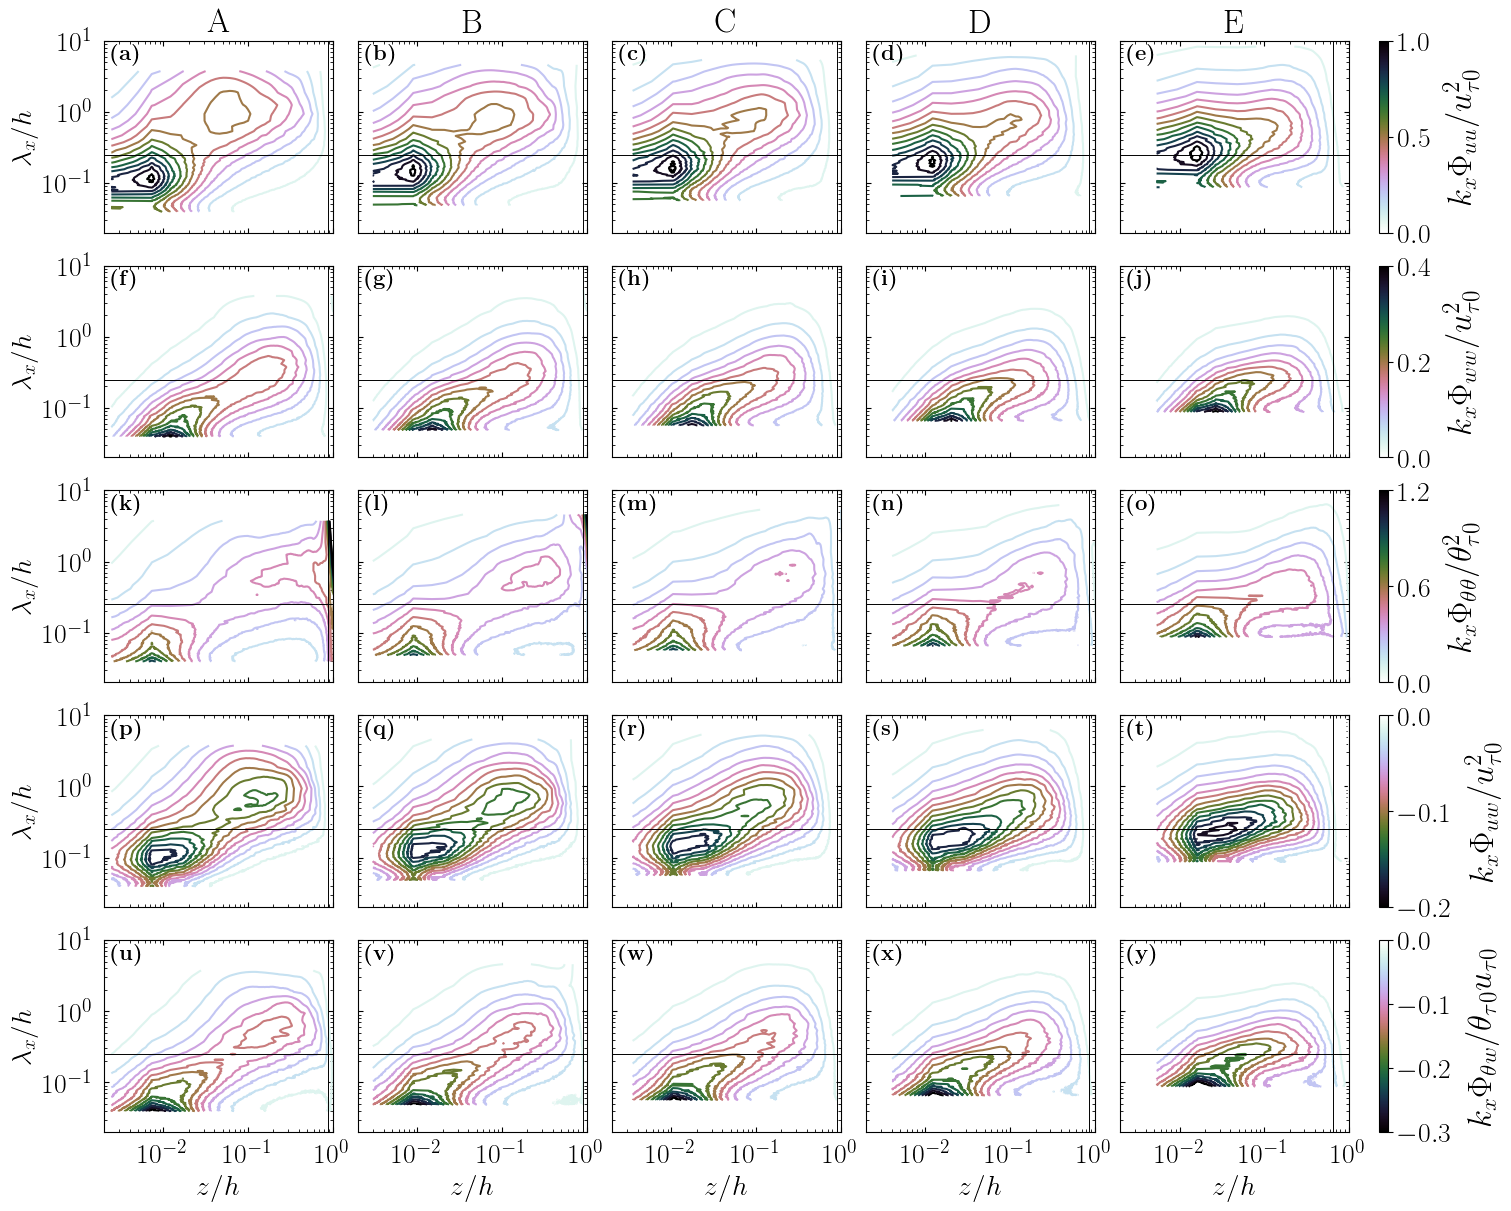

In [19]:
# plot all sims, 1 per column
fig4, ax4 = plt.subplots(nrows=5, ncols=5, constrained_layout=True,
                         sharex=True, sharey=True, 
                         figsize=(3*5, 12))
# plotting parameters
nlevel = 15
# loop over sims
for ii, (s, E) in enumerate(zip(sall, Eall)):
    # row 1
    cax4u = ax4[0,ii].contour(E.z/s.h, 1/E.freq_x/s.h, 
                              E.freq_x*E.uu/s.ustar0/s.ustar0,
                              levels=np.linspace(0.0, 1.0, nlevel), extend="max",
                              cmap=cmap3)
    # row 2
    cax4w = ax4[1,ii].contour(E.z/s.h, 1/E.freq_x/s.h, 
                              E.freq_x*E.ww/s.ustar0/s.ustar0,
                              levels=np.linspace(0.0, 0.4, nlevel), extend="max",
                              cmap=cmap3)
    # row 3
    cax4t = ax4[2,ii].contour(E.z/s.h, 1/E.freq_x/s.h, 
                              E.freq_x*E.tt/s.tstar0/s.tstar0,
                              levels=np.linspace(0.0, 1.2, nlevel), extend="max",
                              cmap=cmap3)
    # row 4
    cax4uw = ax4[3,ii].contour(E.z/s.h, 1/E.freq_x/s.h, 
                               E.freq_x*E.uw/s.ustar0/s.ustar0,
                               levels=np.linspace(-0.2, 0.0, nlevel), extend="min",
                               cmap=cmap3_r)
    # row 5
    cax4tw = ax4[4,ii].contour(E.z/s.h, 1/E.freq_x/s.h, 
                               E.freq_x*E.tw/s.tstar0/s.ustar0,
                               levels=np.linspace(-0.3, 0.0, nlevel), extend="min",
                               cmap=cmap3_r)
    # horizontal line for cutoff wavelength h/4
    # [iax.axhline(0.5, color="k", lw=0.7) for iax in ax4[:,ii]]
    [iax.axhline(0.25, color="k", lw=0.7) for iax in ax4[:,ii]]
    # vertical line for Obukhov length
    # [iax.axvline(s.L/s.h, color="k", lw=0.7) for iax in ax4[:,ii]]
    [iax.axvline(s.z.where(s.Rig >= 0.2, drop=True)[0]/s.h, color="k", lw=0.7) for iax in ax4[:,ii]]
    # title each column for stability
    ax4[0,ii].set_title(s.lab)
# colorbars
normu = Normalize(vmin=cax4u.cvalues.min(), vmax=cax4u.cvalues.max())
smu = plt.cm.ScalarMappable(norm=normu, cmap=cax4u.cmap)
smu.set_array([])
cb4u = fig4.colorbar(smu, ax=ax4[0,:], location="right", 
                     ticks=np.linspace(0., 1.0, 3), pad=0.01)
normw = Normalize(vmin=cax4w.cvalues.min(), vmax=cax4w.cvalues.max())
smw = plt.cm.ScalarMappable(norm=normw, cmap=cax4w.cmap)
smw.set_array([])
cb4w = fig4.colorbar(smw, ax=ax4[1,:], location="right", 
                     ticks=np.linspace(0., 0.4, 3), pad=0.01)
normt = Normalize(vmin=cax4t.cvalues.min(), vmax=cax4t.cvalues.max())
smt = plt.cm.ScalarMappable(norm=normt, cmap=cax4t.cmap)
smt.set_array([])
cb4t = fig4.colorbar(smt, ax=ax4[2,:], location="right", 
                     ticks=np.linspace(0., 1.2, 3), pad=0.01)
normuw = Normalize(vmin=cax4uw.cvalues.min(), vmax=cax4uw.cvalues.max())
smuw = plt.cm.ScalarMappable(norm=normuw, cmap=cax4uw.cmap)
smuw.set_array([])
cb4uw = fig4.colorbar(smuw, ax=ax4[3,:], location="right", 
                      ticks=np.linspace(-0.2, 0., 3), pad=0.01)
normtw = Normalize(vmin=cax4tw.cvalues.min(), vmax=cax4tw.cvalues.max())
smtw = plt.cm.ScalarMappable(norm=normtw, cmap=cax4tw.cmap)
smtw.set_array([])
cb4tw = fig4.colorbar(smtw, ax=ax4[4,:], location="right", 
                      ticks=np.linspace(-0.3, 0., 4), pad=0.01)
# cb labels
cb4u.ax.set_ylabel(r"$k_x \Phi_{uu} / u_{\tau 0}^2$", fontsize=24, labelpad=10, fontweight="bold")
cb4w.ax.set_ylabel(r"$k_x \Phi_{ww} / u_{\tau 0}^2$", fontsize=24, labelpad=10, fontweight="bold")
cb4t.ax.set_ylabel(r"$k_x \Phi_{\theta\theta} / \theta_{\tau 0}^2$", fontsize=24, labelpad=10, fontweight="bold")
cb4uw.ax.set_ylabel(r"$k_x \Phi_{uw} / u_{\tau 0}^2$", fontsize=24, labelpad=10, fontweight="bold")
cb4tw.ax.set_ylabel(r"$k_x \Phi_{\theta w} / \theta_{\tau 0} u_{\tau 0}$", fontsize=24, labelpad=10, fontweight="bold")
# log axes
ax4[0,0].set_xscale("log")
ax4[0,0].set_yscale("log")
ax4[0,0].set_ylim([2e-2, 1e1])
ax4[0,0].set_xlim([2e-3, 1e0])
[iax.set_xlabel("$z/h$") for iax in ax4[-1,:]]
[iax.set_ylabel(r"$\lambda_x / h$") for iax in ax4[:,0]]
# subplot labels
labels = [chr(i) for i in range(ord("a"),ord("z"))]
for iax, lab in zip(ax4.flatten(), labels):
    iax.text(0.03, 0.90, rf"\textbf{{({lab})}}", 
             fontsize=16, transform=iax.transAxes)
# tick lines inside plot
for iax in ax4.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save figure
if savefigs:
    fsave4 = f"{fdir_save}Fig04.pdf"
    fig4.savefig(fsave4, format="pdf")

## Figure 5: LCS contours

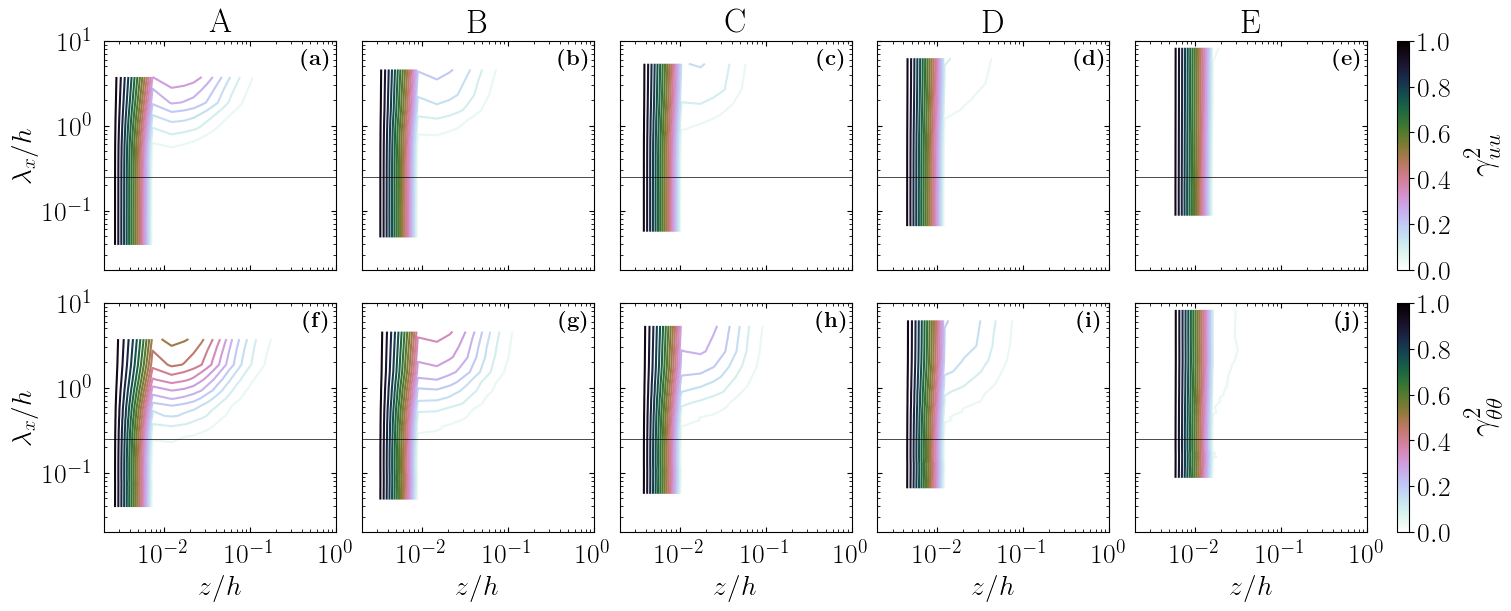

In [20]:
# plot all sims, 1 per column
fig5, ax5 = plt.subplots(nrows=2, ncols=5, constrained_layout=True,
                         sharex=True, sharey=True, 
                         figsize=(15, 6))
levelGu = np.linspace(0, 1, 21)
levelGw = np.linspace(0, 0.05, 11)
levelGt = np.linspace(0, 1, 21)
# loop over sims
for ii, (s, g) in enumerate(zip(sall, Gall)):
    # G2u
    cax5u = ax5[0,ii].contour(g.z/s.h, 1./g.freq_x/s.h, g.u0, cmap=cmap3, levels=levelGu)
    # G2w
    # cax5w = ax5[1,ii].contour(g.z/s.zj, 1./g.freq_x/s.zj, g.w0, cmap=cmap3, levels=levelGw)
    # G2t
    cax5t = ax5[1,ii].contour(g.z/s.h, 1./g.freq_x/s.h, g.t0, cmap=cmap3, levels=levelGt)
    # dashed vert line for L/h
    # [iax.axvline(s.L/s.h, color="k", lw=0.5) for iax in ax3[:,ii]]
    # dashed horiz line for zj/2
    [iax.axhline(0.25, color="k", lw=0.5) for iax in ax5[:,ii]]
    # title columns
    ax5[0,ii].set_title(s.lab)
# colorbars
normu = Normalize(vmin=cax5u.cvalues.min(), vmax=cax5u.cvalues.max())
smu = plt.cm.ScalarMappable(norm=normu, cmap=cax5u.cmap)
smu.set_array([])
cb5u = fig5.colorbar(smu, ax=ax5[0,:], location="right", 
                     ticks=MultipleLocator(0.2), pad=0.01)
# cb5w = fig5.colorbar(cax5w, ax=ax5[1,:], location="right", 
#                      ticks=MultipleLocator(0.01), pad=0.01)
normt = Normalize(vmin=cax5t.cvalues.min(), vmax=cax5t.cvalues.max())
smt = plt.cm.ScalarMappable(norm=normt, cmap=cax5u.cmap)
smt.set_array([])
cb5t = fig5.colorbar(smt, ax=ax5[1,:], location="right", 
                     ticks=MultipleLocator(0.2), pad=0.01)
# cb labels
cb5u.ax.set_ylabel(r"$\gamma_{uu}^2$", fontsize=24, labelpad=10, fontweight="bold")
# cb5w.ax.set_ylabel("$\\gamma_{ww}^2$", fontsize=24, labelpad=10, fontweight="bold")
cb5t.ax.set_ylabel(r"$\gamma_{\theta \theta}^2$", fontsize=24, labelpad=10, fontweight="bold")
# make axes log-log
ax5[0,0].set_xscale("log")
ax5[0,0].set_yscale("log")
# axis limits
ax5[0,0].set_ylim([2e-2, 1e1])
ax5[0,0].set_xlim([2e-3, 1e0])
# axis labels
[iax.set_xlabel("$z/h$") for iax in ax5[-1,:]]
[iax.set_ylabel(r"$\lambda_x / h$") for iax in ax5[:,0]]
# subplot labels
labels = [chr(i) for i in range(ord("a"),ord("k"))]
for iax, lab in zip(ax5.flatten(), labels):
    iax.text(0.6, 6, rf"\textbf{{({lab})}}", 
             fontsize=16, ha="center", va="center")
# tick lines inside plot
for iax in ax5.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save figure
if savefigs:
    fsave5 = f"{fdir_save}Fig05.pdf"
    fig5.savefig(fsave5, format="pdf")

## Figure 6: LCS at same height

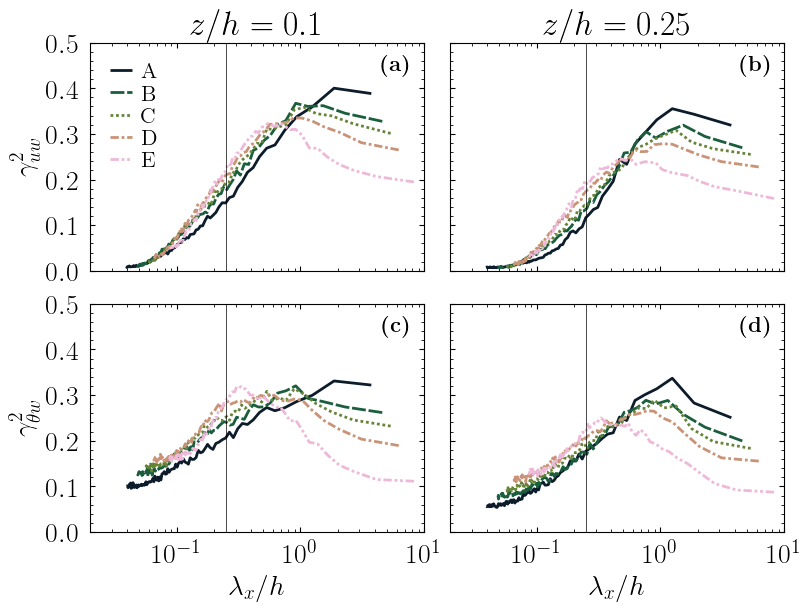

In [21]:
# plot uw and tw separately (rows), all stabilities for given height (col)
# row 1: uw
# row 2: tw
# col 1: z/h = 0.1
# col 2: z/h = 0.5
# col 3: z/h = 1.0
fig6, ax6 = plt.subplots(nrows=2, ncols=2, constrained_layout=True,
                         sharex=True, sharey=True, 
                         figsize=(8, 6))
# loop over sims
for ii, (s, g) in enumerate(zip(sall, Gall)):
    # row 1
    zh = g.z / s.h
    jz1 = abs(zh - 0.1).argmin()
    jz2 = abs(zh - 0.25).argmin()
    # jz2 = abs(g.z - s.zj/2).argmin()
    jz3 = abs(zh - 0.5).argmin()
    # plot
    ax6[0,0].plot(1./g.freq_x/s.h, g.uw.isel(z=jz1), label=s.lab, c=cmap[ii], ls=dash[ii], lw=2)
    ax6[0,1].plot(1./g.freq_x/s.h, g.uw.isel(z=jz2), label=s.lab, c=cmap[ii], ls=dash[ii], lw=2)
    # ax6[0,2].plot(1./g.freq_x/s.zj, g.uw.isel(z=jz3), label=s.lab, c=cmap[ii], ls=dash[ii], lw=2)
    # row 2
    ax6[1,0].plot(1./g.freq_x/s.h, g.tw.isel(z=jz1), label=s.lab, c=cmap[ii], ls=dash[ii], lw=2)
    ax6[1,1].plot(1./g.freq_x/s.h, g.tw.isel(z=jz2), label=s.lab, c=cmap[ii], ls=dash[ii], lw=2)
    # ax6[1,2].plot(1./g.freq_x/s.zj, g.tw.isel(z=jz3), label=s.lab, c=cmap[ii], ls=dash[ii], lw=2)
# label columns
for iax, zz in zip(ax6[0,:], [0.1, 0.25]):
    iax.set_title(f"$z/h = {{{zz}}}$")
# vertical line on each for lambda_x/z_j = 1
for iax in ax6.flatten():
    iax.axvline(0.25, lw=0.5, c="k", ls="-")
# label axes
ax6[0,0].set_ylabel(r"$\gamma^2_{uw}$")
ax6[1,0].set_ylabel(r"$\gamma^2_{\theta w}$")
for iax in ax6[-1,:]:
    iax.set_xlabel(r"$\lambda_x / h$")
# x-axis log
ax6[0,0].set_xscale("log")
# axis limits
ax6[0,0].set_xlim([2e-2, 1e1])
ax6[0,0].set_ylim([0, 0.5])
# axis ticks
ax6[0,0].yaxis.set_major_locator(MultipleLocator(0.1))
ax6[0,0].yaxis.set_minor_locator(MultipleLocator(0.02))
# legend
ax6[0,0].legend(frameon=False, labelspacing=0.10, ncol=1, columnspacing=1,
                handletextpad=0.4, handlelength=1, loc="upper left",
                fontsize=16)
# subplot labels
labels = [chr(i) for i in range(ord("a"),ord("e"))]
for iax, lab in zip(ax6.flatten(), labels):
    iax.text(6, 0.45, rf"\textbf{{({lab})}}", 
             fontsize=16, ha="center", va="center")
# tick lines inside plot
for iax in ax6.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save figure
if savefigs:
    fsave6 = f"{fdir_save}Fig06.pdf"
    fig6.savefig(fsave6, format="pdf")

## Figure 7: Transport efficiency profiles

$\eta_{uw}$, $\eta_{\theta w}$, ratio

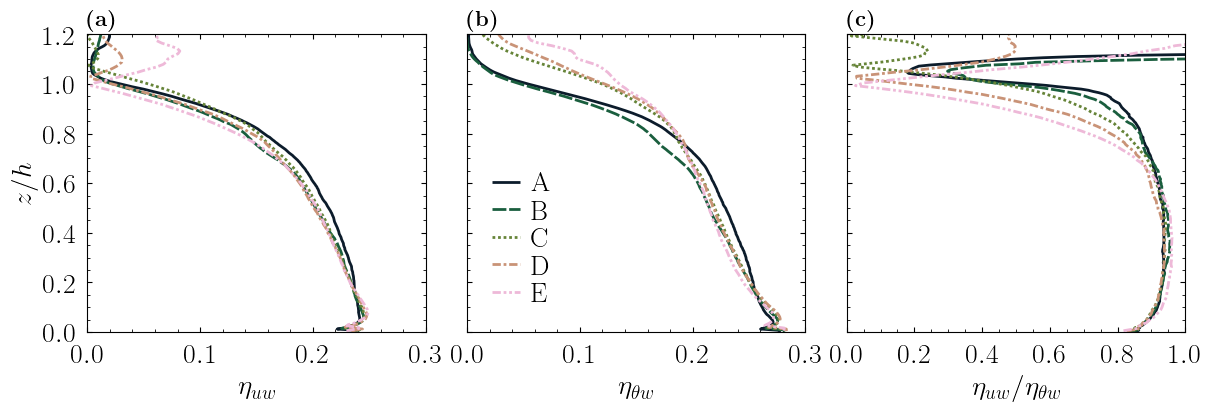

In [24]:
fig7, ax7 = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12,4), constrained_layout=True)
for ii, (s, q) in enumerate(zip(sall, quadall)):
    # eta_uw
    ax7[0].plot(q.eta_uw, q.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # eta_tw
    ax7[1].plot(q.eta_tw, q.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # eta_uw/eta_tw
    ax7[2].plot(q.eta_uw/q.eta_tw, q.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
# vertical line for ratio = 1
# ax7[2].axvline(1, lw=0.5, c="k")
# legend
ax7[1].legend(frameon=False, labelspacing=0.10,# ncol=2, columnspacing=1,
                handletextpad=0.4, handlelength=1, loc="lower left")
# x axis limits
ax7[0].set_xlim([0, 0.3])
ax7[1].set_xlim([0, 0.3])
ax7[2].set_xlim([0, 1.0])
# x axis ticks
ax7[0].xaxis.set_major_locator(MultipleLocator(0.1))
ax7[0].xaxis.set_minor_locator(MultipleLocator(0.02))
ax7[1].xaxis.set_major_locator(MultipleLocator(0.1))
ax7[1].xaxis.set_minor_locator(MultipleLocator(0.02))
ax7[2].xaxis.set_major_locator(MultipleLocator(0.2))
ax7[2].xaxis.set_minor_locator(MultipleLocator(0.05))
# y axis limits
ax7[0].set_ylim([0, 1.2])
# y axis ticks
ax7[0].yaxis.set_major_locator(MultipleLocator(0.2))
ax7[0].yaxis.set_minor_locator(MultipleLocator(0.05))
# axis labels
ax7[0].set_ylabel("$z/h$")
ax7[0].set_xlabel(r"$\eta_{uw}$")
ax7[1].set_xlabel(r"$\eta_{\theta w}$")
ax7[2].set_xlabel(r"$\eta_{uw} / \eta_{\theta w}$")
# subplot labels
labels = [chr(i) for i in range(ord("a"),ord("d"))]
for iax, lab in zip(ax7.flatten(), labels):
    # iax.text(0.93, 0.93, rf"\textbf{{({lab})}}", 
    #          fontsize=16, ha="center", va="center", transform=iax.transAxes)
    iax.set_title(rf"\textbf{{({lab})}}", loc="left", fontsize=16)
# tick lines inside plot
for iax in ax7.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)

# save figure
if savefigs:
    fsave7 = f"{fdir_save}Fig07.pdf"
    fig7.savefig(fsave7, format="pdf")

## Figure 8: Quadrant fraction profiles

In [27]:
fig8, ax8 = plt.subplots(nrows=2, ncols=4, sharey=True, sharex="row", figsize=(14.8, 8), constrained_layout=True)
# loop over simulations
for ii, (s, quad) in enumerate(zip(sall, quadall)):
    # row 1: u'w'
    # quadrant I: u+w+
    ax8[0,0].plot(np.abs(quad.uw_pp)/np.abs(quad.uw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # quadrant II: u-w+
    ax8[0,1].plot(np.abs(quad.uw_np)/np.abs(quad.uw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # quadrant III: u-w-
    ax8[0,2].plot(np.abs(quad.uw_nn)/np.abs(quad.uw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # quadrant IV: u+w-
    ax8[0,3].plot(np.abs(quad.uw_pn)/np.abs(quad.uw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # row 2: theta'w'
    # quadrant I: T+w+
    ax8[1,0].plot(np.abs(quad.tw_pp)/np.abs(quad.tw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # quadrant II: T-w+
    ax8[1,1].plot(np.abs(quad.tw_np)/np.abs(quad.tw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # quadrant III: T-w-
    ax8[1,2].plot(np.abs(quad.tw_nn)/np.abs(quad.tw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # quadrant IV: T+w-
    ax8[1,3].plot(np.abs(quad.tw_pn)/np.abs(quad.tw_sum), s.z/s.h, 
                  ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
# legend
ax8[0,1].legend(frameon=False, labelspacing=0.10,# ncol=2, columnspacing=0.7,
                handletextpad=0.4, handlelength=1, loc=(0.02, 0.02))
# y axis limits
ax8[0,0].set_ylim([0., 1.2])
# y axis ticks
ax8[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax8[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
# y axis labels
for iax in ax8[:,0]:
    iax.set_ylabel("$z/h$")
# x axis limits
ax8[0,0].set_xlim([0, 0.5])
ax8[1,0].set_xlim([0, 0.5])
# x axis ticks
ax8[0,0].xaxis.set_major_locator(MultipleLocator(0.1))
ax8[0,0].xaxis.set_minor_locator(MultipleLocator(0.02))
ax8[1,0].xaxis.set_major_locator(MultipleLocator(0.1))
ax8[1,0].xaxis.set_minor_locator(MultipleLocator(0.02))
# x axis labels - hacky but works
qlab = [r"\normalsize"+rf"\hbox{{{ii}}}" for ii in ["I", "II", "III", "IV"]]
for iax, iq in zip(ax8[0,:], qlab):
    iax.set_xlabel(f"$Q^{{{iq}}}_{{uw}}$")
for iax, iq in zip(ax8[1,:], qlab):
    iax.set_xlabel(rf"$Q^{{{iq}}}_{{\theta w}}$")
# plot vertical reference lines and subplot labels
labels = [chr(i) for i in range(ord("a"),ord("i"))]
for iax, lab in zip(ax8.flatten(), labels):
    iax.axvline(0.25, color="k", lw=0.5)
    iax.text(0.45, 1.1, rf"\textbf{{({lab})}}", 
             fontsize=16, ha="center", va="center")
# tick lines inside plot
for iax in ax8.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)

# save figure
if savefigs:
    fsave8 = f"{fdir_save}Fig08.pdf"
    fig8.savefig(fsave8, format="pdf")

In [ ]:
q = quadall[0]
q

## Figure 9: Joint PDFs and Premultiplied Joint PDFs

In [28]:
# define function to return full 2d histograms of PDF(uw), uwPDF(uw), PDF(tw), twPDF(tw)
def get_2d_hist(sall, pall, jz):

    H_uw_all, uwP_uw_all, H_tw_all, twP_tw_all = [[] for _ in range(4)]

    for s, p in zip(sall, pall):
        # u'w'
        uw_bins = (np.arange(-10, 10.1, 0.1), np.arange(-10., 10.1, 0.1))
        # look at just one height for now
        # calculate bins and edges
        H_uw, x_uw, y_uw = np.histogram2d(p.u.isel(z=jz).values/s.ustar0.values, 
                                          p.w.isel(z=jz).values/s.ustar0.values, 
                                          bins=uw_bins, density=True)
        # store H_uw
        H_uw_all.append(H_uw)
        # calculate bin centers
        x1 = x_uw[:-1] + np.diff(x_uw)/2
        y1 = y_uw[:-1] + np.diff(y_uw)/2

        # calculate covariance integrand, uwP(u,w)
        # intialize empty array
        uwP_uw = np.zeros((H_uw.shape), dtype=np.float64)

        # loop over H_uw bins and fill uwP_uw
        for jx in range(0, x_uw.size-1):
            for jy in range(0, y_uw.size-1):
                uwP_uw[jx,jy] = x1[jx]*y1[jy]*H_uw[jx,jy]
        # store uwP_uw
        uwP_uw_all.append(uwP_uw)

        # theta'w'
        tw_bins = (np.arange(-15, 15.1, 0.1), np.arange(-10., 10.1, 0.1))
        # look at just one height for now
        # calculate bins and edges
        H_tw, x_tw, y_tw = np.histogram2d(p.theta.isel(z=jz).values/s.tstar0.values, 
                                          p.w.isel(z=jz).values/s.ustar0.values, 
                                          bins=tw_bins, density=True)
        # store H_tw
        H_tw_all.append(H_tw)
        # calculate bin centers
        x2 = x_tw[:-1] + np.diff(x_tw)/2
        y2 = y_tw[:-1] + np.diff(y_tw)/2

        # calculate covariance integrand, uwP(u,w)
        # intialize empty array
        twP_tw = np.zeros((H_tw.shape), dtype=np.float64)

        # loop over H_uw bins and fill uwP_uw
        for jx in range(0, x_tw.size-1):
            for jy in range(0, y_tw.size-1):
                twP_tw[jx,jy] = x2[jx]*y2[jy]*H_tw[jx,jy]
        # store twP_tw
        twP_tw_all.append(twP_tw)

    return [H_uw_all, uwP_uw_all, H_tw_all, twP_tw_all, x1, y1, x2, y2]

In [29]:
# call and get data
H_uw_all1, uwP_uw_all1, H_tw_all1, twP_tw_all1, x1, y1, x2, y2 = get_2d_hist(sall[::2], pall[::2], 0)
H_uw_all2, uwP_uw_all2, H_tw_all2, twP_tw_all2, _, _, _, _ = get_2d_hist(sall[::2], pall[::2], 2)

Saving figure /home/bgreene/SBL_LES/figures/LSM/final/Fig09.pdf


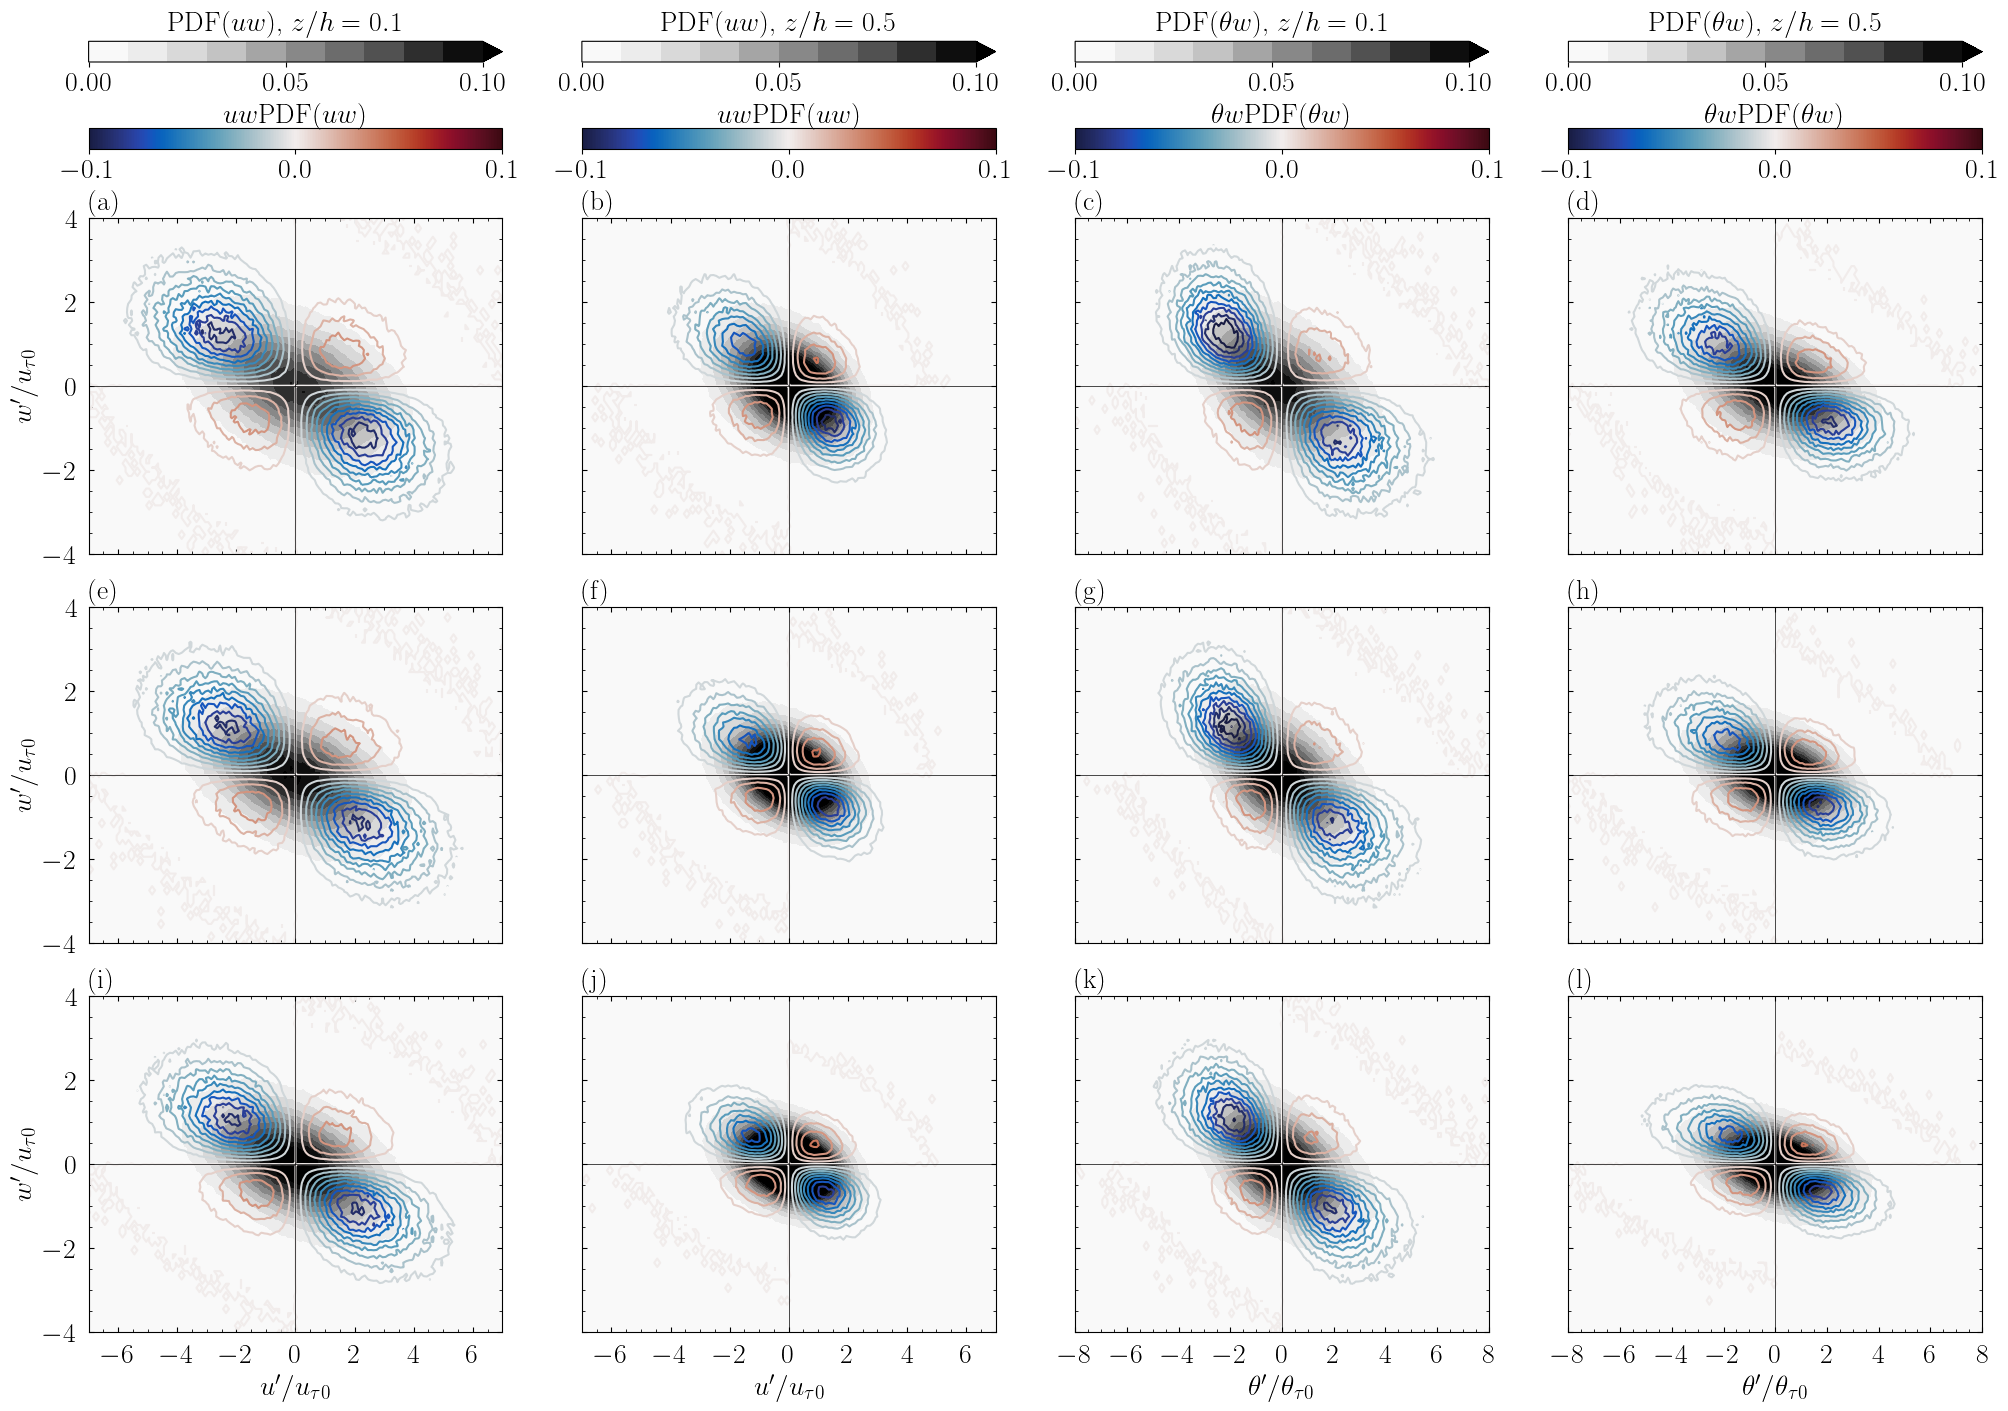

In [30]:
fig9, ax9 = plt.subplots(nrows=3, ncols=4, figsize=(20, 14), sharex="col", sharey=True,
                           constrained_layout=True)
# contour
uwlevels = np.linspace(0, 0.1, 11)
uwPlevels = np.linspace(-0.1, 0.1, 21)
twlevels = np.linspace(0, 0.1, 11)
twPlevels = np.linspace(-0.1, 0.1, 21)
# loop and plot: z/zj=0.1
for ii, (H_uw, uwP_uw, H_tw, twP_tw) in enumerate(zip(H_uw_all1, uwP_uw_all1, H_tw_all1, twP_tw_all1)):
    # column 1: P(uw), uwP(uw), z/zj=0.1
    cax1 = ax9[ii,0].contourf(x1, y1, H_uw.T, cmap="Greys", extend="max", levels=uwlevels)
    cax2 = ax9[ii,0].contour(x1, y1, uwP_uw.T, cmap=cmap2, extend="both", levels=uwPlevels)
    # column 3: P(tw)
    cax3 = ax9[ii,2].contourf(x2, y2, H_tw.T, cmap="Greys", extend="max", levels=twlevels)
    cax4 = ax9[ii,2].contour(x2, y2, twP_tw.T, cmap=cmap2, extend="both", levels=twPlevels)
    if ii == 0:
        # add colorbars at top of columns
        # ax1
        cb1 = fig9.colorbar(cax1, ax=ax9[:,0], location="top", pad=0.005, ticks=[0, 0.05, 0.1])
        # ax2; continuous contour levels
        norm2 = Normalize(vmin=cax2.cvalues.min(), vmax=cax2.cvalues.max())
        sm2 = plt.cm.ScalarMappable(norm=norm2, cmap=cax2.cmap)
        sm2.set_array([])
        cb2 = fig9.colorbar(sm2, ax=ax9[:,0], location="top", pad=0.005, ticks=[-0.1, 0, 0.1])
        # ax3
        cb3 = fig9.colorbar(cax3, ax=ax9[:,2], location="top", pad=0.005, ticks=[0, 0.05, 0.1])
        # ax4; continuous contour levels
        norm4 = Normalize(vmin=cax4.cvalues.min(), vmax=cax4.cvalues.max())
        sm4 = plt.cm.ScalarMappable(norm=norm4, cmap=cax4.cmap)
        sm4.set_array([])
        cb4 = fig9.colorbar(sm4, ax=ax9[:,2], location="top", pad=0.005, ticks=[-0.1, 0, 0.1])
# colorbar labels
cb1.ax.set_xlabel("PDF($uw$), $z/h=0.1$", labelpad=8)
cb2.ax.set_xlabel("$uw$PDF($uw$)")
cb3.ax.set_xlabel(r"PDF($\theta w$), $z/h=0.1$", labelpad=8)
cb4.ax.set_xlabel(r"$\theta w$PDF($\theta w$)")
# colorbar ticks below
cb1.ax.xaxis.set_ticks_position("bottom")
cb2.ax.xaxis.set_ticks_position("bottom")
cb3.ax.xaxis.set_ticks_position("bottom")
cb4.ax.xaxis.set_ticks_position("bottom")

# repeat for z/zj=0.5
# loop and plot: z/zj=0.1
for ii, (H_uw, uwP_uw, H_tw, twP_tw) in enumerate(zip(H_uw_all2, uwP_uw_all2, H_tw_all2, twP_tw_all2)):
    # column 1: P(uw), uwP(uw), z/zj=0.1
    cax5 = ax9[ii,1].contourf(x1, y1, H_uw.T, cmap="Greys", extend="max", levels=uwlevels)
    cax6 = ax9[ii,1].contour(x1, y1, uwP_uw.T, cmap=cmap2, extend="both", levels=uwPlevels)
    # column 3: P(tw)
    cax7 = ax9[ii,3].contourf(x2, y2, H_tw.T, cmap="Greys", extend="max", levels=twlevels)
    cax8 = ax9[ii,3].contour(x2, y2, twP_tw.T, cmap=cmap2, extend="both", levels=twPlevels)
    if ii == 0:
        # add colorbars at top of columns
        # ax5
        cb5 = fig9.colorbar(cax5, ax=ax9[:,1], location="top", pad=0.005, ticks=[0, 0.05, 0.1])
        # ax6; continuous contour levels
        norm6 = Normalize(vmin=cax6.cvalues.min(), vmax=cax6.cvalues.max())
        sm6 = plt.cm.ScalarMappable(norm=norm6, cmap=cax6.cmap)
        sm6.set_array([])
        cb6 = fig9.colorbar(sm6, ax=ax9[:,1], location="top", pad=0.005, ticks=[-0.1, 0, 0.1])
        # ax7
        cb7 = fig9.colorbar(cax7, ax=ax9[:,3], location="top", pad=0.005, ticks=[0, 0.05, 0.1])
        # ax8; continuous contour levels
        norm8 = Normalize(vmin=cax8.cvalues.min(), vmax=cax8.cvalues.max())
        sm8 = plt.cm.ScalarMappable(norm=norm8, cmap=cax8.cmap)
        sm8.set_array([])
        cb8 = fig9.colorbar(sm8, ax=ax9[:,3], location="top", pad=0.005, ticks=[-0.1, 0, 0.1])
# colorbar labels
cb5.ax.set_xlabel("PDF($uw$), $z/h=0.5$", labelpad=8)
cb6.ax.set_xlabel("$uw$PDF($uw$)")
cb7.ax.set_xlabel(r"PDF($\theta w$), $z/h=0.5$", labelpad=8)
cb8.ax.set_xlabel(r"$\theta w$PDF($\theta w$)")
# colorbar ticks below
cb5.ax.xaxis.set_ticks_position("bottom")
cb6.ax.xaxis.set_ticks_position("bottom")
cb7.ax.xaxis.set_ticks_position("bottom")
cb8.ax.xaxis.set_ticks_position("bottom")

# vertical and horizontal lines at x=0, y=0
[iax.axhline(0., c="k", lw=0.5) for iax in ax9.flatten()]
[iax.axvline(0., c="k", lw=0.5) for iax in ax9.flatten()]
# add labels
ax9[-1,0].set_xlabel(r"$u'/u_{\tau0}$")
ax9[-1,1].set_xlabel(r"$u'/u_{\tau0}$")
ax9[-1,2].set_xlabel(r"$\theta'/\theta_{\tau0}$")
ax9[-1,3].set_xlabel(r"$\theta'/\theta_{\tau0}$")
[iax.set_ylabel(r"$w'/u_{\tau0}$") for iax in ax9[:,0]]
# axis limits
ax9[0,0].set_ylim([-4, 4])
ax9[0,0].set_xlim([-7, 7])
ax9[0,1].set_xlim([-7, 7])
ax9[0,2].set_xlim([-8, 8])
ax9[0,3].set_xlim([-8, 8])
# axis tick labels
ax9[0,0].yaxis.set_major_locator(MultipleLocator(2))
ax9[0,0].yaxis.set_minor_locator(MultipleLocator(0.5))
[iax.xaxis.set_major_locator(MultipleLocator(2)) for iax in ax9[-1,:]]
[iax.xaxis.set_minor_locator(MultipleLocator(0.5)) for iax in ax9[-1,:]]
# subplot labels
labels = [chr(i) for i in range(ord("a"),ord("m"))]
for iax, lab in zip(fig9.axes, labels):
    iax.set_title(f"({lab})", fontsize=20, loc="left")
# tick lines inside plot
for iax in ax9.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save
if savefigs:
    fsave9 = f"{fdir_save}Fig09.pdf"
    print(f"Saving figure {fsave9}")
    fig9.savefig(fsave9, format="pdf")

## Figure 10: AM Coefficients versus $z/h$

Saving figure /home/bgreene/SBL_LES/figures/LSM/final/Fig10.pdf


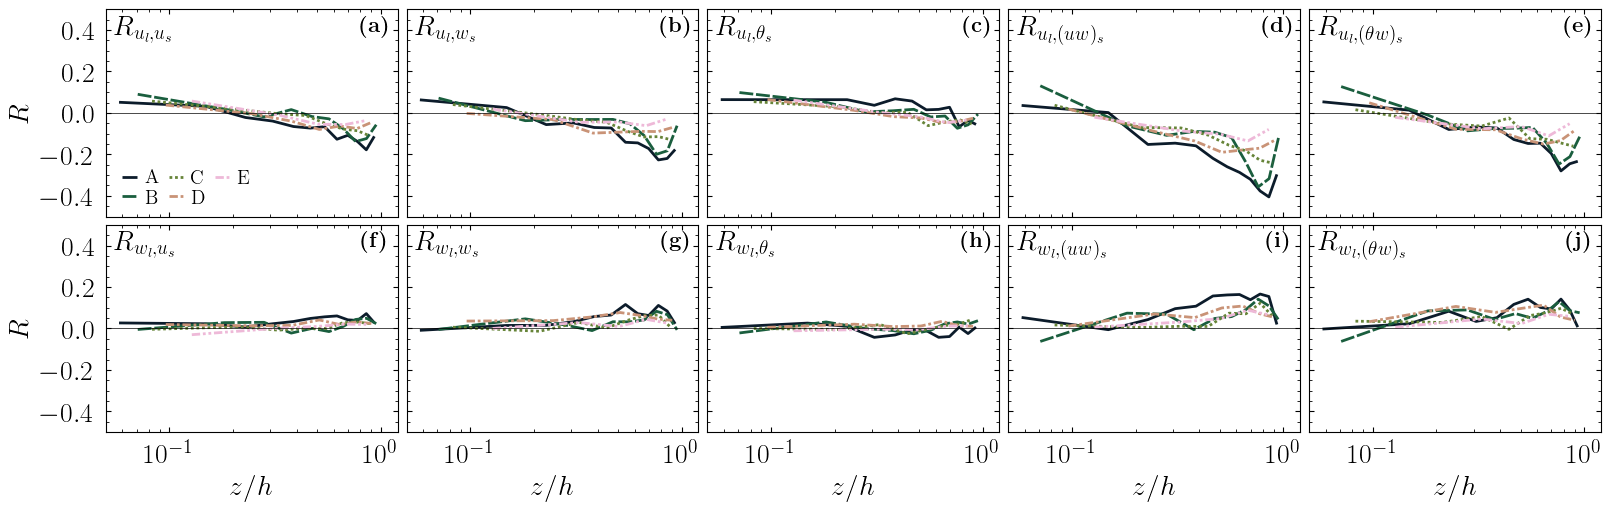

In [32]:
fig10, ax10 = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,
                         figsize=(16, 5), constrained_layout=True)
for isim, (R, stat) in enumerate(zip(Rall, sall)):
    # grab indices for sbl
    isbl = np.arange(stat.nzabl, dtype=np.int32)
    # add z/h as coordinate and swap with z
    # define array of z/h
    zh = R.z / stat.h
    # assign coupled with z
    R = R.assign_coords(zh=("z",zh.values))
    # swap
    R = R.swap_dims({"z": "zh"})
    # define number of points per bin
    Nperbin = 16
    # calculate total number of bins based on number of points
    Nbin = int(np.ceil(len(zh)/Nperbin))
    # define new zh bins based on averages of zh
    zhbin = []
    # loop through zh
    for jbin in range(Nbin):
        # define incrementing indices
        ilo = jbin * Nperbin
        ihi = ilo + Nperbin
        # check to see if ihi will be out of range
        if ihi >= len(zh):
            ihi = -1
        # grab zh data
        zhbin.append(gmean(zh[ilo:ihi]))
    # convert to numpy array
    zhbin = np.array(zhbin)
    # from this, also need len(zhbin)-1 with midpoints of bins for plotting
    zhnew = [] # define empty array
    for iz in range(Nbin-1):
        zhnew.append(gmean([zhbin[iz], zhbin[iz+1]]))
    zhnew = np.array(zhnew)
    # group by zh bins and calculate mean in one line
    Rbin = R.groupby_bins("zh", zhbin).mean("zh", skipna=True)
    # create new coordinate "zh_bins", then swap and drop
    Rbin = Rbin.assign_coords({"zh": ("zh_bins", zhnew)}).swap_dims({"zh_bins": "zh"})
    # interpolate empty values for better plotting
    Rbin = Rbin.interpolate_na(dim="zh")
    # calculate indeces of points where z/zj <= h/zj
    isblbin = np.where(zhnew <= 1)[0]
    # Plot ------------------------------------------------
    # figure 1 - fifteen panels - modulation by u_l and w_l and t_l
    # row 1 - modulation by u_l
    # row 2 - modulation by t_l
    # col 1 - modulation of small-scale u by large-scale u&w&t
    # col 2 - modulation of small-scale w by large-scale u&w&t
    # col 3 - modulation of small-scale theta by large-scale u&w&t
    # col 4 - modulation of small-scale uw by large-scale u&w&t
    # col 5 - modulation of small-scale tw by large-scale u&w&t
    # (a) R_ul_Eu
    ax10[0,0].plot(Rbin.zh[isblbin], Rbin.ul_Eu[isblbin], ls=dash[isim], c=cmap[isim], lw=2,
                    label=stat.lab)
    # (b) R_tl_Eu
    ax10[1,0].plot(Rbin.zh[isblbin], Rbin.wl_Eu[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (c) R_ul_Ew
    ax10[0,1].plot(Rbin.zh[isblbin], Rbin.ul_Ew[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (d) R_tl_Ew
    ax10[1,1].plot(Rbin.zh[isblbin], Rbin.wl_Ew[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (e) R_ul_Et
    ax10[0,2].plot(Rbin.zh[isblbin], Rbin.ul_Et[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (f) R_tl_Et
    ax10[1,2].plot(Rbin.zh[isblbin], Rbin.wl_Et[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (g) R_ul_Euw
    ax10[0,3].plot(Rbin.zh[isblbin], Rbin.ul_Euw[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (h) R_tl_Euw
    ax10[1,3].plot(Rbin.zh[isblbin], Rbin.wl_Euw[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (i) R_ul_Etw
    ax10[0,4].plot(Rbin.zh[isblbin], Rbin.ul_Etw[isblbin], ls=dash[isim], c=cmap[isim], lw=2)
    # (j) R_tl_Etw
    ax10[1,4].plot(Rbin.zh[isblbin], Rbin.wl_Etw[isblbin], ls=dash[isim], c=cmap[isim], lw=2)

# OUTSIDE LOOP
# axis labels
for iax in ax10[1,:]:
    iax.set_xlabel("$z/h$")
for iax in ax10[:,0]:
    iax.set_ylabel("$R$")
# axis limits
ax10[0,0].set_xlim([5e-2, 1.2e0])
ax10[0,0].set_ylim([-0.5, 0.5])
# major and minor ticks
ax10[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax10[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
# axis scale
ax10[0,0].set_xscale("log")
# legend
ax10[0,0].legend(loc=(0.03, 0.01), labelspacing=0.10, 
                handletextpad=0.4, handlelength=0.75,
                fontsize=14, frameon=False, ncol=3, columnspacing=0.5)
# plot ref lines
for iax in ax10.flatten():
    iax.axhline(0, c="k", ls="-", lw=0.5)
    # iax.axvline(0.5, c="k", ls="-", lw=0.5)
# text labels
FS = 20
ax10[0,0].text(0.03, 0.88, "$R_{u_l,u_s}$", fontsize=FS, transform=ax10[0,0].transAxes)
ax10[1,0].text(0.03, 0.88, "$R_{w_l,u_s}$", fontsize=FS, transform=ax10[1,0].transAxes)
ax10[0,1].text(0.03, 0.88, "$R_{u_l,w_s}$", fontsize=FS, transform=ax10[0,1].transAxes)
ax10[1,1].text(0.03, 0.88, "$R_{w_l,w_s}$", fontsize=FS, transform=ax10[1,1].transAxes)
ax10[0,2].text(0.03, 0.88, r"$R_{u_l,\theta_s}$", fontsize=FS, transform=ax10[0,2].transAxes)
ax10[1,2].text(0.03, 0.88, r"$R_{w_l,\theta_s}$", fontsize=FS, transform=ax10[1,2].transAxes)
ax10[0,3].text(0.03, 0.88, "$R_{u_l,(uw)_s}$", fontsize=FS, transform=ax10[0,3].transAxes)
ax10[1,3].text(0.03, 0.88, "$R_{w_l,(uw)_s}$", fontsize=FS, transform=ax10[1,3].transAxes)
ax10[0,4].text(0.03, 0.88, r"$R_{u_l,(\theta w)_s}$", fontsize=FS, transform=ax10[0,4].transAxes)
ax10[1,4].text(0.03, 0.88, r"$R_{w_l,(\theta w)_s}$", fontsize=FS, transform=ax10[1,4].transAxes)
# subplot labels
for iax, lab in zip(ax10.flatten(), list("abcdefghij")):
    iax.text(0.95, 0.42, rf"\textbf{{({lab})}}", fontsize=16, ha="center", va="center")
# tick lines inside plot
for iax in ax10.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save
if savefigs:
    fsave10 = f"{fdir_save}Fig10.pdf"
    print(f"Saving figure {fsave10}")
    fig10.savefig(fsave10, format="pdf")

## Figure 11: AM coefficients versus $Ri_g$

In [35]:
nbin = 16
# define bin *edges*
Ribin = np.logspace(-2, np.log10(0.5), nbin)
# create dictionary of empty lists for each key in Rall
Rd = {}
for key in R.variables.keys():
    if ((key != "z") & ("_int" not in key)):
        Rd[key] = [[] for _ in range(nbin-1)]

# loop over simulations and fill Rd
for R, s in zip(Rall, sall):
    # grab Ri values from s (only within sbl)
    # isbl = np.arange(s.nzabl, dtype=np.int32)
    isbl = np.where(s.z.values <= s.h.values)[0]
    Ri = s.Rig[isbl].values
    # loop over bins
    for ibin in range(1, nbin):
        jmean = np.where((Ri >= Ribin[ibin-1]) & (Ri < Ribin[ibin]))[0]
        # loop over variables and store in Rd
        for key in Rd.keys():
            Rd[key][ibin-1] += list(R[key][jmean].values)

# calculate bin centers for plotting
Riplot = []
for ibin in range(nbin-1):
    Riplot.append(gmean([Ribin[ibin], Ribin[ibin+1]]))
Riplot = np.array(Riplot)

# calculate mean, median, std of each bin for each param
Rplot = {}
for key in Rd.keys():
    # loop over bins with list comprehension (average each in list of lists)
    # mean
    Rplot[f"{key}_mean"] = np.array([np.mean(jbin) for jbin in Rd[key]])
    # median
    Rplot[f"{key}_med"] = np.array([np.median(jbin) for jbin in Rd[key]])
    # std
    Rplot[f"{key}_std"] = np.array([np.std(jbin) for jbin in Rd[key]])

/home/bgreene/anaconda3/envs/LES/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/bgreene/anaconda3/envs/LES/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/bgreene/anaconda3/envs/LES/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/bgreene/anaconda3/envs/LES/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/bgreene/anaconda3/envs/LES/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Saving figure /home/bgreene/SBL_LES/figures/LSM/final/Fig11.pdf


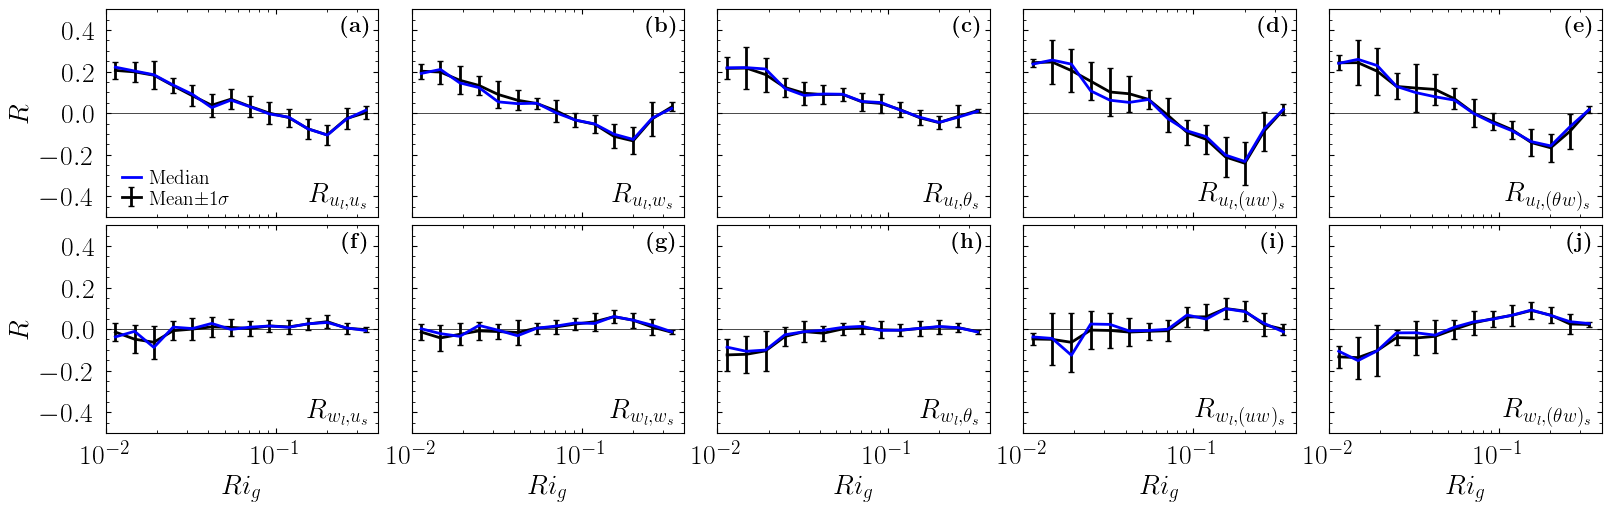

In [36]:
# now can plot using data from Rplot
fig11, ax11 = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,
                           figsize=(16, 5), constrained_layout=True)

# figure 1 - fifteen panels - modulation by u_l and t_l
# row 1 - modulation by u_l
# row 2 - modulation by t_l
# col 1 - modulation of small-scale u by large-scale u&w&t
# col 2 - modulation of small-scale w by large-scale u&w&t
# col 3 - modulation of small-scale theta by large-scale u&w&t
# col 4 - modulation of small-scale uw by large-scale u&w&t
# col 5 - modulation of small-scale tw by large-scale u&w&t
# plot mean and median as lines
# shade std around mean
# (a) R_ul_Eu
# ax2[0,0].plot(Riplot, Rplot["ul_Eu_mean"], ls="-", c="k", lw=2, label="Mean")
ax11[0,0].errorbar(Riplot, Rplot["ul_Eu_mean"], yerr=Rplot["ul_Eu_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[0,0].plot(Riplot, Rplot["ul_Eu_med"], ls="-", c="b", lw=2, label="Median", zorder=1000)

# (b) R_tl_Eu
# ax2[1,0].plot(Riplot, Rplot["tl_Eu_mean"], ls="-", c="k", lw=2)
ax11[1,0].errorbar(Riplot, Rplot["wl_Eu_mean"], yerr=Rplot["wl_Eu_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[1,0].plot(Riplot, Rplot["wl_Eu_med"], ls="-", c="b", lw=2, zorder=1000)

# (c) R_ul_Ew
# ax2[0,1].plot(Riplot, Rplot["ul_Ew_mean"], ls="-", c="k", lw=2)
ax11[0,1].errorbar(Riplot, Rplot["ul_Ew_mean"], yerr=Rplot["ul_Ew_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[0,1].plot(Riplot, Rplot["ul_Ew_med"], ls="-", c="b", lw=2, zorder=1000)

# (d) R_tl_Ew
# ax2[1,1].plot(Riplot, Rplot["tl_Ew_mean"], ls="-", c="k", lw=2)
ax11[1,1].errorbar(Riplot, Rplot["wl_Ew_mean"], yerr=Rplot["wl_Ew_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[1,1].plot(Riplot, Rplot["wl_Ew_med"], ls="-", c="b", lw=2, zorder=1000)

# (e) R_ul_Et
# ax2[0,2].plot(Riplot, Rplot["ul_Et_mean"], ls="-", c="k", lw=2)
ax11[0,2].errorbar(Riplot, Rplot["ul_Et_mean"], yerr=Rplot["ul_Et_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[0,2].plot(Riplot, Rplot["ul_Et_med"], ls="-", c="b", lw=2, zorder=1000)

# (f) R_tl_Et
# ax2[1,2].plot(Riplot, Rplot["tl_Et_mean"], ls="-", c="k", lw=2)
ax11[1,2].errorbar(Riplot, Rplot["wl_Et_mean"], yerr=Rplot["wl_Et_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[1,2].plot(Riplot, Rplot["wl_Et_med"], ls="-", c="b", lw=2, zorder=1000)

# (g) R_ul_Euw
# ax2[0,3].plot(Riplot, Rplot["ul_Euw_mean"], ls="-", c="k", lw=2)
ax11[0,3].errorbar(Riplot, Rplot["ul_Euw_mean"], yerr=Rplot["ul_Euw_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[0,3].plot(Riplot, Rplot["ul_Euw_med"], ls="-", c="b", lw=2, zorder=1000)

# (h) R_tl_Euw
# ax2[1,3].plot(Riplot, Rplot["tl_Euw_mean"], ls="-", c="k", lw=2)
ax11[1,3].errorbar(Riplot, Rplot["wl_Euw_mean"], yerr=Rplot["wl_Euw_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[1,3].plot(Riplot, Rplot["wl_Euw_med"], ls="-", c="b", lw=2, zorder=1000)

# (i) R_ul_Etw
# ax2[0,4].plot(Riplot, Rplot["ul_Etw_mean"], ls="-", c="k", lw=2)
ax11[0,4].errorbar(Riplot, Rplot["ul_Etw_mean"], yerr=Rplot["ul_Etw_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[0,4].plot(Riplot, Rplot["ul_Etw_med"], ls="-", c="b", lw=2, zorder=1000)

# (j) R_wl_Etw
# ax2[1,4].plot(Riplot, Rplot["tl_Etw_mean"], ls="-", c="k", lw=2)
ax11[1,4].errorbar(Riplot, Rplot["wl_Etw_mean"], yerr=Rplot["wl_Etw_std"], 
                   c="k", ls="-", lw=2, label=r"Mean$\pm 1 \sigma$", capsize=2, capthick=1)
ax11[1,4].plot(Riplot, Rplot["wl_Etw_med"], ls="-", c="b", lw=2, zorder=1000)

# axis labels
for iax in ax11[1,:]:
    iax.set_xlabel("$Ri_g$")
for iax in ax11[:,0]:
    iax.set_ylabel("$R$")
# axis limits
ax11[0,0].set_xlim([1e-2, 4e-1])
# ax2[0,0].set_xlim([0, 0.3])
ax11[0,0].set_ylim([-0.5, 0.5])
# major and minor ticks
ax11[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax11[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
# axis scale
ax11[0,0].set_xscale("log")
# legend
ax11[0,0].legend(loc=(0.03, 0.01), labelspacing=0.10, 
                 handletextpad=0.4, handlelength=1,
                 fontsize=14, frameon=False)
# plot ref lines
for iax in ax11.flatten():
    iax.axhline(0, c="k", ls="-", lw=0.5)
    # iax.axvline(0.5, c="k", ls="-", lw=0.5)
# text labels
ax11[0,0].text(0.35, -0.4, "$R_{u_l,u_s}$", fontsize=20, ha="right", va="center")
ax11[1,0].text(0.35, -0.4, "$R_{w_l,u_s}$", fontsize=20, ha="right", va="center")
ax11[0,1].text(0.35, -0.4, "$R_{u_l,w_s}$", fontsize=20, ha="right", va="center")
ax11[1,1].text(0.35, -0.4, "$R_{w_l,w_s}$", fontsize=20, ha="right", va="center")
ax11[0,2].text(0.35, -0.4, r"$R_{u_l,\theta_s}$", fontsize=20, ha="right", va="center")
ax11[1,2].text(0.35, -0.4, r"$R_{w_l,\theta_s}$", fontsize=20, ha="right", va="center")
ax11[0,3].text(0.35, -0.4, "$R_{u_l,(uw)_s}$", fontsize=20, ha="right", va="center")
ax11[1,3].text(0.35, -0.4, "$R_{w_l,(uw)_s}$", fontsize=20, ha="right", va="center")
ax11[0,4].text(0.35, -0.4, r"$R_{u_l,(\theta w)_s}$", fontsize=20, ha="right", va="center")
ax11[1,4].text(0.35, -0.4, r"$R_{w_l,(\theta w)_s}$", fontsize=20, ha="right", va="center")
# subplot labels
for iax, lab in zip(ax11.flatten(), list("abcdefghij")):
    iax.text(0.3, 0.42, rf"\textbf{{({lab})}}", fontsize=16, ha="center", va="center")

# tick lines inside plot
for iax in ax11.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)

# save
if savefigs:
    fsave11 = f"{fdir_save}Fig11.pdf"
    print(f"Saving figure {fsave11}")
    fig11.savefig(fsave11, format="pdf")

## Figure 12: Conditionally averaged fields

Saving figure: /home/bgreene/SBL_LES/figures/LSM/final/Fig12.png


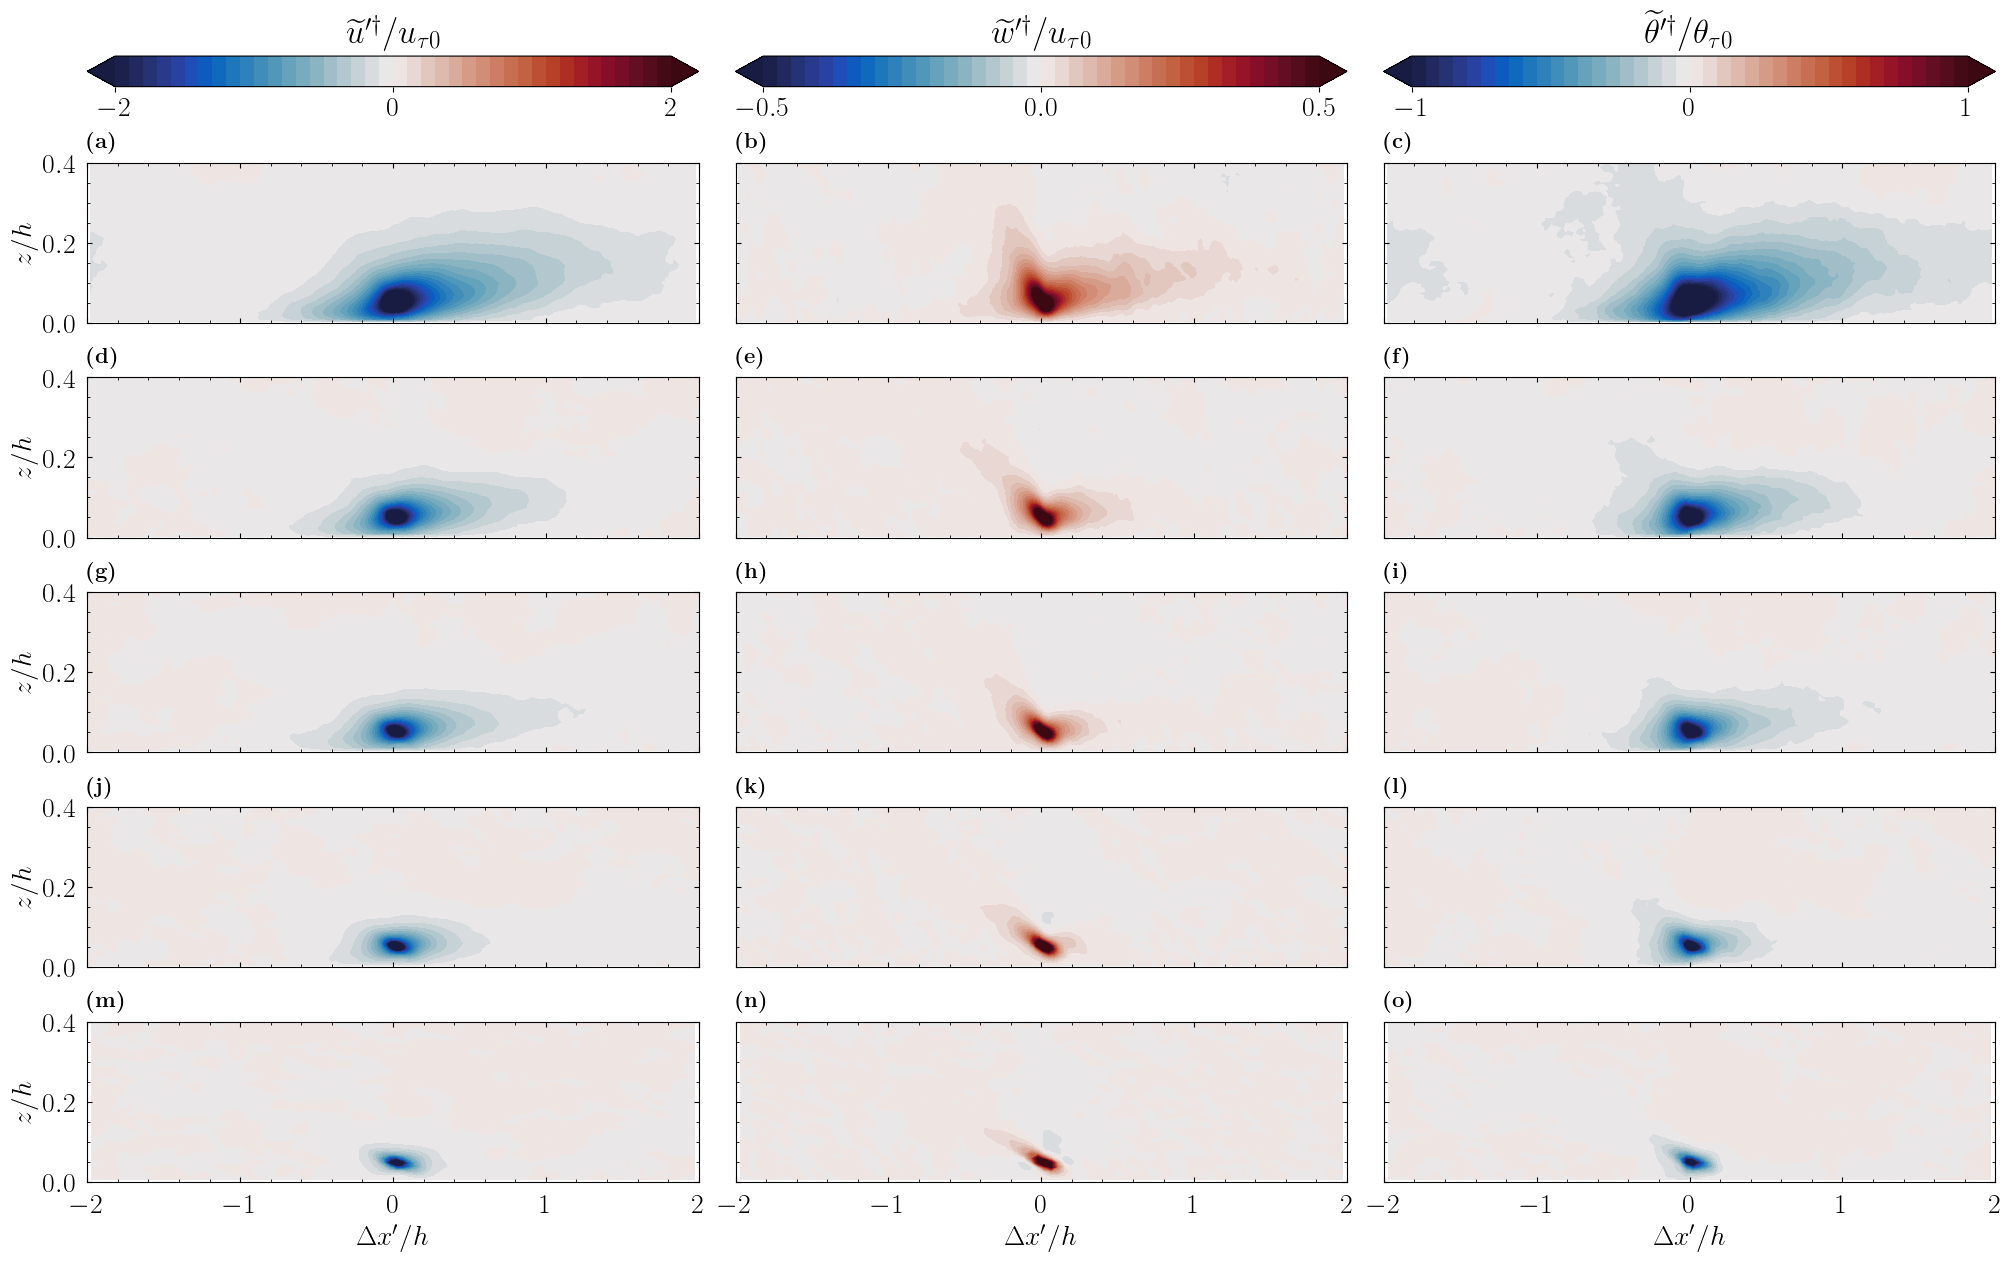

In [38]:
fig12, ax12 = plt.subplots(nrows=5, ncols=3, sharex=True, sharey=True, 
                           constrained_layout=True, figsize=(20, 2.5*5))
# 1 row per stability, 3 columns for u, w, theta
# define contour levels
levelu = np.linspace(-2, 2, 41)
levelw = np.linspace(-0.5, 0.5, 41)
levelt = np.linspace(-1, 1, 41)
# loop over stabilities
for ii, (s, c) in enumerate(zip(sall, condall)):
    # u
    cfu = ax12[ii,0].contourf(c.x/s.h, c.z/s.h, c.u_cond_u_lo.T, 
                              extend="both", cmap=cmap2, levels=levelu)
    # w
    cfw = ax12[ii,1].contourf(c.x/s.h, c.z/s.h, c.w_cond_u_lo.T, 
                              extend="both", cmap=cmap2, levels=levelw)
    # theta
    cft = ax12[ii,2].contourf(c.x/s.h, c.z/s.h, c.t_cond_u_lo.T, 
                              extend="both", cmap=cmap2, levels=levelt)
# colorbars above each column
cbu = fig12.colorbar(cfu, ax=ax12[:,0], location="top",
                    ticks=[-2, 0, 2], pad=0.01)
cbw = fig12.colorbar(cfw, ax=ax12[:,1], location="top", 
                    ticks=[-0.5, 0, 0.5], pad=0.01)
cbt = fig12.colorbar(cft, ax=ax12[:,2], location="top", 
                    ticks=[-1, 0, 1], pad=0.01)
# cb ticks
cbu.ax.xaxis.set_ticks_position("bottom")
cbw.ax.xaxis.set_ticks_position("bottom")
cbt.ax.xaxis.set_ticks_position("bottom")
# cb labels
cbu.ax.set_xlabel(r"$\widetilde{u}'^{\dagger}/u_{\tau 0}$", fontsize=24, labelpad=10, fontweight="bold")
cbw.ax.set_xlabel(r"$\widetilde{w}'^{\dagger}/u_{\tau 0}$", fontsize=24, labelpad=10, fontweight="bold")
cbt.ax.set_xlabel(r"$\widetilde{\theta}'^{\dagger}/\theta_{\tau 0}$", fontsize=24, labelpad=10, fontweight="bold")
# axis limits
ax12[0,0].set_ylim([0, 0.4])
ax12[0,0].set_xlim([-2, 2])
# axis ticks
ax12[0,0].xaxis.set_major_locator(MultipleLocator(1))
ax12[0,0].xaxis.set_minor_locator(MultipleLocator(0.2))
ax12[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax12[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
# axis labels
for iax in ax12[:,0]:
    iax.set_ylabel("$z/h$")
for iax in ax12[-1,:]:
    iax.set_xlabel(r"$\Delta x' / h$")
# subplot labels
labels = [chr(i) for i in range(ord("a"),ord("p"))]
for iax, lab in zip(ax12.flatten(), labels):
    iax.text(-2, 0.45, rf"\textbf{{({lab})}}", 
             fontsize=16, ha="left", va="center")
# tick lines inside plot
for iax in ax12.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save figure
if savefigs:
    fsave12 = f"{fdir_save}Fig12.png"
    print(f"Saving figure: {fsave12}")
    fig12.savefig(fsave12, format="png", dpi=300)

# Test figures

### Spectra to exemplify ISR

In [ ]:
fig13, ax13 = plt.subplots(nrows=1, ncols=2, figsize=(14.8, 5))

zzi = 0.25

for ii, (s, E) in enumerate(zip(sall, Eall)):
    jz = abs((s.z/s.h).values - zzi).argmin()
    print(jz)
    # u variance spectrum
    ax13[0].loglog(E.freq_x, E.uu.isel(z=jz), label=s.lab, 
                   ls=dash[ii], lw=2, c=cmap[ii])
    # w variance spectrum
    ax13[1].loglog(E.freq_x, E.ww.isel(z=jz),
                   ls=dash[ii], lw=2, c=cmap[ii])
    
k53x = np.array([1e-2, 2e-1])
k53y = 0.005 * k53x ** (-5./3)
ax13[0].loglog(k53x, k53y, "--k", label="$k_x^{-5/3}$", lw=2)
ax13[1].loglog(k53x, 0.6*k53y, "--k", lw=2)

ax13[0].set_xlabel("$k_{x'}$ [m$^{-1}$]")
ax13[0].set_ylabel("$\\Phi_{uu}$ [m$^3$ s$^{-2}$]")
ax13[1].set_xlabel("$k_{x'}$ [m$^{-1}$]")
ax13[1].set_ylabel("$\\Phi_{ww}$ [m$^3$ s$^{-2}$]")

ax13[0].legend(frameon=False, labelspacing=0.10, ncol=2, columnspacing=1,
               handletextpad=0.4, handlelength=1, loc="lower left")
fig13.suptitle(f"$z/h = {{{zzi}}}$")

if savefigs:
    fig13.savefig(f"{fdir_save}uu_ww_1d_spectra.pdf", bbox_inches="tight")

In [ ]:
import xrft
dnc = dnc_all[0]
d = xr.load_dataset(dnc+"all_1260000.nc")

In [ ]:
u = d.w

PSD = xrft.power_spectrum(u, dim="x", true_phase=True, true_amplitude=True,
                          detrend_type="linear")
PSD_yavg = PSD.mean(dim=("y"))

Euu = PSD_yavg.where(PSD_yavg.freq_x > 0, drop=True)

In [ ]:
plt.loglog(Euu.freq_x, Euu.isel(z=188))
k53x = np.array([1e-2, 2e-1])
k53y = 0.005 * k53x ** (-5./3)
plt.loglog(k53x, k53y, "--k", label="$k_x^{-5/3}$", lw=2)

In [ ]:
for s, E in zip(sall, Eall):
    # T_SB = z_LLJ / U_LLJ
    s.attrs["T_SB"] = s.zj / s.uh.max()
    # Lambda_x = lambda_x | kx*Euu = max(kx*Euu)
    # look at z/zj = 0.5
    jz = abs(s.z/s.zj - 0.05).argmin()
    jkx = (E.freq_x * E.uu.isel(z=jz)).argmax()
    Lambda_x = 1/E.freq_x[jkx]
    # q = sqrt(2 * TKE)
    q = np.sqrt(2 * s.e.isel(z=jz))
    # T_L = Lambda_x / q
    s.attrs["T_L"] = Lambda_x / q
    # SBstar = T_L / T_SB
    s.attrs["SBstar"] = s.T_L / s.T_SB

    print(s.SBstar.values)

In [ ]:
# anisotropy stuff
# NOTE: does not include SGS terms...we do not output tau_xy so this is incomplete :(
from scipy import linalg
# load these cases
dd1, s1 = load_full(dnc_all[0], 1260000, 1260000, 1000, 0.02, fstat, False)
dd2, s2 = load_full(dnc_all[4], 1260000, 1260000, 1000, 0.02, fstat, False)

ll1, ll2 = [np.zeros((192,3), dtype=np.float64) for _ in range(2)]

u1, v1, w1 = dd1.u.isel(time=0), dd1.v.isel(time=0), dd1.w.isel(time=0)
u2, v2, w2 = dd2.u.isel(time=0), dd2.v.isel(time=0), dd2.w.isel(time=0)

for jz in range(192):
    # case 1
    up1 = (u1.isel(z=jz) - u1.isel(z=jz).mean()).to_numpy()
    vp1 = (v1.isel(z=jz) - v1.isel(z=jz).mean()).to_numpy()
    wp1 = (w1.isel(z=jz) - w1.isel(z=jz).mean()).to_numpy()
    # case 2
    up2 = (u2.isel(z=jz) - u2.isel(z=jz).mean()).to_numpy()
    vp2 = (v2.isel(z=jz) - v2.isel(z=jz).mean()).to_numpy()
    wp2 = (w2.isel(z=jz) - w2.isel(z=jz).mean()).to_numpy()
    # assemble 3-component velocity list
    V1 = [up1, vp1, wp1]
    V2 = [up2, vp2, wp2]
    # calculate 2*TKE == ee
    ee1 = np.mean(up1*up1) + np.mean(vp1*vp1) + np.mean(wp1*wp1)
    ee2 = np.mean(up2*up2) + np.mean(vp2*vp2) + np.mean(wp2*wp2)
    # initialize empty bij arrays and fill up
    bij1, bij2 = [np.zeros((3,3), dtype=np.float64) for _ in range(2)]
    # loop over i, j
    for i in range(3):
        for j in range(3):
            bij1[i,j] = np.mean(V1[i]*V1[j])/ee1
            bij2[i,j] = np.mean(V2[i]*V2[j])/ee2
    # subtract off 1/3 from trace
    bij1 -= np.identity(3)*(1./3)
    bij2 -= np.identity(3)*(1./3)
    # calculate eigenvalues of bij, sort in descending order
    ll1[jz,:] = np.sort(linalg.eig(bij1)[0].real)[::-1]
    ll2[jz,:] = np.sort(linalg.eig(bij2)[0].real)[::-1]
# convert eigenvalues into barycentric invariants
xB1 = ll1[:,0] - ll1[:,1] + 0.5*(3*ll1[:,2] + 1)
yB1 = (np.sqrt(3)/2) * (3*ll1[:,2] + 1)
xB2 = ll2[:,0] - ll2[:,1] + 0.5*(3*ll2[:,2] + 1)
yB2 = (np.sqrt(3)/2) * (3*ll2[:,2] + 1)

In [ ]:
# plot 
s1 = sall[0]
s2 = sall[4]
plt.figure(figsize=(8,7))
plt.scatter(xB1[:s1.nzabl], yB1[:s1.nzabl], c="r", label=s1.lab)
plt.scatter(xB2[:s2.nzabl], yB2[:s2.nzabl], c="b", label=s2.lab)
# triangle outline
xx = np.array([0, 1, 0.5, 0])
yy = np.array([0, 0, np.sqrt(3)/2, 0])
plt.plot(xx, yy, "-k", lw=3)
plt.legend(frameon=False)

plt.xlim([0, 1])
plt.ylim([0, np.sqrt(3)/2])

plt.xlabel("$x_B$")
plt.ylabel("$y_B$")

## Demonstrate effects of averaging time on $384^3$ simulations

In [ ]:
# load stats files: 8-9h, 9-10h, 8-10h
sdir = "/home/bgreene/simulations/SBL/cr0.10_384/output/netcdf/"
s89 = load_stats(f"{sdir}mean_stats_xyt_8-9h.nc")
s910 = load_stats(f"{sdir}mean_stats_xyt_9-10h.nc")
s810 = load_stats(f"{sdir}mean_stats_xyt_8-10h.nc")
slist = [s89, s910, s810]
# give some attrs
labs = ["8-9h", "9-10h", "8-10h"]
clist = ["k", "r", "b"]
for js, s in enumerate(slist):
    s.attrs["lab"] = labs[js]
    s.attrs["color"] = clist[js]

In [ ]:
fig2, ax2 = plt.subplots(nrows=3, ncols=3, sharey=True, 
                         figsize=(14.8, 15), constrained_layout=True)
for i, s in enumerate(slist):
    # now plot
    # row 1
    # (a) Uh
    ax2[0,0].plot(s.uh/8, s.z/s.zj, c=s.color, lw=2, label=s.lab)
    # (b) <\theta>
    ax2[0,1].plot((s.theta_mean-s.theta_mean[0])/s.tstar0, s.z/s.zj, c=s.color, lw=2, label=s.lab)
    # (c) Rig
    ax2[0,2].plot(s.Rig, s.z/s.zj, c=s.color, lw=2)
    # row 2
    # (d) ustar^2
    ax2[1,0].plot(s.ustar2/s.ustar0/s.ustar0, s.z/s.zj, c=s.color, lw=2)
    # (e) <\theta'w'>
    ax2[1,1].plot(s.tw_cov_tot/s.ustar0/s.tstar0, s.z/s.zj, c=s.color, lw=2)
    # (f) <\theta'^2>
    ax2[1,2].plot(s.theta_var/s.tstar0/s.tstar0, s.z/s.zj, c=s.color, lw=2)
    # row 3
    # (g) <\u'^2>
    ax2[2,0].plot(s.u_var_rot/s.ustar0/s.ustar0, s.z/s.zj, c=s.color, lw=2)
    # (h) <\v'^2>
    ax2[2,1].plot(s.v_var_rot/s.ustar0/s.ustar0, s.z/s.zj, c=s.color, lw=2)
    # (i) <w'^2>
    ax2[2,2].plot(s.w_var/s.ustar0/s.ustar0, s.z/s.zj, c=s.color, lw=2)
# clean up
# (a)
ax2[0,0].set_xlabel("$U_h/G$")
ax2[0,0].set_ylabel("$z/z_j$")
ax2[0,0].set_xlim([0, 1.2])
ax2[0,0].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[0,0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[0,0].set_ylim([0, 1.1])
ax2[0,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax2[0,0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax2[0,0].text(0.87,0.05,r'\textbf{(a)}',fontsize=20,bbox=props, 
              transform=ax2[0,0].transAxes)
ax2[0,0].legend(frameon=False, labelspacing=0.10,
                handletextpad=0.4, handlelength=1, loc="upper left")
# (b)
ax2[0,1].set_xlabel("$(\\Theta - \\Theta_0)/\\theta_{\\tau0}$")
ax2[0,1].set_xlim([0, 60])
ax2[0,1].xaxis.set_major_locator(MultipleLocator(10))
ax2[0,1].xaxis.set_minor_locator(MultipleLocator(2))
ax2[0,1].text(0.87,0.05,r'\textbf{(b)}',fontsize=20,bbox=props, 
              transform=ax2[0,1].transAxes)
# (c)
ax2[0,2].set_xlabel("$Ri_g$")
ax2[0,2].set_xlim([0, 1.])
ax2[0,2].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[0,2].xaxis.set_minor_locator(MultipleLocator(0.1))
ax2[0,2].text(0.87,0.05,r'\textbf{(c)}',fontsize=20,bbox=props, 
              transform=ax2[0,2].transAxes)
# (d)
ax2[1,0].set_xlabel("$u_{\\tau}^2 / u_{\\tau 0}^2$")
ax2[1,0].set_ylabel("$z/z_j$")
ax2[1,0].set_xlim([0, 1.15])
ax2[1,0].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[1,0].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[1,0].text(0.03,0.05,r'\textbf{(d)}',fontsize=20,bbox=props, 
              transform=ax2[1,0].transAxes)
# (e)
ax2[1,1].set_xlabel("$\\langle \\widetilde{\\theta}'\\widetilde{w}' + \\pi_3^{\\theta} \\rangle / \\theta_{\\tau 0} u_{\\tau 0}$")
ax2[1,1].set_xlim([-1.15, 0])
ax2[1,1].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[1,1].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[1,1].text(0.87,0.05,r'\textbf{(e)}',fontsize=20,bbox=props, 
              transform=ax2[1,1].transAxes)
# (f)
ax2[1,2].set_xlabel("$\\langle \\widetilde{\\theta}'^2 \\rangle/\\theta_{\\tau 0}^2$")
ax2[1,2].set_xlim([0, 20])
ax2[1,2].xaxis.set_major_locator(MultipleLocator(5))
ax2[1,2].xaxis.set_minor_locator(MultipleLocator(1))
ax2[1,2].text(0.87,0.05,r'\textbf{(f)}',fontsize=20,bbox=props, 
              transform=ax2[1,2].transAxes)
# (g)
ax2[2,0].set_xlabel("$\\langle \\tilde{u}'^2 \\rangle/u_{\\tau 0}^2$")
ax2[2,0].set_ylabel("$z/z_j$")
ax2[2,0].set_xlim([0, 6])
ax2[2,0].xaxis.set_major_locator(MultipleLocator(1))
ax2[2,0].xaxis.set_minor_locator(MultipleLocator(0.5))
ax2[2,0].set_ylim([0, 1.1])
ax2[2,0].yaxis.set_major_locator(MultipleLocator(0.2))
ax2[2,0].yaxis.set_minor_locator(MultipleLocator(0.05))
ax2[2,0].text(0.03,0.05,r'\textbf{(g)}',fontsize=20,bbox=props, 
              transform=ax2[2,0].transAxes)
# (h)
ax2[2,1].set_xlabel("$\\langle \\tilde{v}'^2 \\rangle/u_{\\tau 0}^2$")
ax2[2,1].set_xlim([0, 3])
ax2[2,1].xaxis.set_major_locator(MultipleLocator(1))
ax2[2,1].xaxis.set_minor_locator(MultipleLocator(0.5))
ax2[2,1].text(0.03,0.05,r'\textbf{(h)}',fontsize=20,bbox=props, 
              transform=ax2[2,1].transAxes)
# (i)
ax2[2,2].set_xlabel("$\\langle \\tilde{w}'^2 \\rangle/u_{\\tau 0}^2$")
ax2[2,2].set_xlim([0, 1.4])
ax2[2,2].xaxis.set_major_locator(MultipleLocator(0.2))
ax2[2,2].xaxis.set_minor_locator(MultipleLocator(0.05))
ax2[2,2].text(0.03,0.05,r'\textbf{(i)}',fontsize=20,bbox=props, 
              transform=ax2[2,2].transAxes)

# tick lines inside plot
for iax in ax2.flatten():
    iax.tick_params(which="both", direction="in", top=True, right=True, pad=8)
# save
if savefigs:
    fig2.savefig(f"{fdir_save}mean_prof_8-9-10h.pdf", format="pdf")

### Timeseries files for hrs 8--10

In [ ]:
ts = load_timeseries(dnc_all[0], detrend=True, tlab="2h")

In [ ]:
nt = ts.t.size
ustar2 = (ts.uw**2. + ts.vw**2.) ** 0.5

In [ ]:
jz = abs((ts.z/sall[0].zj) - 0.6).argmin()
(ts.uu.isel(z=jz)/ustar2.isel(z=0).mean()).plot(figsize=(14.8, 5))
plt.plot(ts.t[:nt//2], ts.uu.isel(z=jz, t=range(0, nt//2)).mean().values*np.ones(nt//2)/ustar2.isel(z=0, t=range(0, nt//2)).mean().values)
plt.plot(ts.t[nt//2:], ts.uu.isel(z=jz, t=range(nt//2, nt)).mean().values*np.ones(nt//2)/ustar2.isel(z=0, t=range(nt//2, nt)).mean().values)
plt.plot(ts.t, ts.uu.isel(z=jz).mean().values*np.ones(nt)/ustar2.isel(z=0).mean().values)
plt.ylim([0, 20])

In [ ]:
jz = abs((ts.z/sall[0].zj) - 0.75).argmin()
plt.figure(figsize=(14.8, 5))

ts.td.isel(z=jz, t=range(180000, 360000)).rolling(t=500).mean().plot()
# ts.ud.isel(z=jz, t=range(180000, 360000)).rolling(t=500).mean().plot()
ts.wd.isel(z=jz, t=range(180000, 360000)).rolling(t=500).mean().plot()

In [ ]:
fig = plt.figure(figsize=(10, 5))

for jt in range(20):
    ((ts.theta - ts.theta.isel(z=0)).sel(t=6000+jt*2).isel(z=range(192)) + 0.2*jt).plot(y="z")

In [ ]:
ts.theta.sel(t=range(6200, 7200)).isel(z=range(200)).plot(y="z", figsize=(20, 5))
# plt.axvline(6700, c="k", lw=2)
# x_adv = 6700 + (800./ts.u_mean.values)
# plt.plot(x_adv, ts.z, c="k", lw=2)

In [ ]:
(dd1.theta - dd1.theta.mean(dim=("x","y"))).isel(z=130).plot(x="x")
plt.axhline(dd1.x[dd1.nx//2], c="k", lw=2)
plt.axvline(dd1.y[dd1.ny//2], c="k", lw=2)

# Timeseries of wind direction over simulation
### Start with cr0.10_u08_192

In [ ]:
# load data instead of rerunning above
dnc = "/home/bgreene/simulations/SBL/cr0.10_384/output/netcdf/"
dd1 = xr.load_dataset(f"{dnc}u_v_ws_wd.nc")
dd2 = xr.load_dataset(f"{dnc}u_v_ws_wd_128.nc")
s = load_stats(dnc+"mean_stats_xyt_8-10h.nc")

In [ ]:
# start plotting
fig14, ax14 = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True, figsize=(14.8, 10))
# define u, v, ws, wd levels
levelu = np.linspace(0, 10, 21)
levelv = np.linspace(0, 4, 21)
levelws = np.linspace(0, 10, 21)
levelwd = np.linspace(210, 300, 21)

# row 1: u
cax14_0 = ax14[0].contourf(dd1.time, dd1.z, dd1.u_mean, cmap=cmap3, levels=levelu)
ax14[0].contourf(dd2.time+10000*0.04/3600, dd2.z, dd2.u_mean, cmap=cmap3, levels=levelu)
# row 2: v
cax14_1 = ax14[1].contourf(dd1.time, dd1.z, dd1.v_mean, cmap=cmap3, levels=levelv)
ax14[1].contourf(dd2.time+10000*0.04/3600, dd2.z, dd2.v_mean, cmap=cmap3, levels=levelv)
# row 3: wspd
cax14_2 = ax14[2].contourf(dd1.time, dd1.z, dd1.uh, cmap=cmap3, levels=levelws)
ax14[2].contourf(dd2.time+10000*0.04/3600, dd2.z, dd2.uh, cmap=cmap3, levels=levelws)
# row 4: wdir
cax14_3 = ax14[3].contourf(dd1.time, dd1.z, dd1.wdir, cmap=cmap3, levels=levelwd)
ax14[3].contourf(dd2.time+10000*0.04/3600, dd2.z, dd2.wdir, cmap=cmap3, levels=levelwd)

# colorbars
cb14_0 = fig14.colorbar(cax14_0, ax=ax14[0], ticks=MultipleLocator(2))
cb14_1 = fig14.colorbar(cax14_1, ax=ax14[1], ticks=MultipleLocator(1))
cb14_2 = fig14.colorbar(cax14_2, ax=ax14[2], ticks=MultipleLocator(2))
cb14_3 = fig14.colorbar(cax14_3, ax=ax14[3], ticks=MultipleLocator(30))
# colorbar labels
cb14_0.ax.set_ylabel("$\\langle u \\rangle_{xy}$ [m s$^{-1}$]")
cb14_1.ax.set_ylabel("$\\langle v \\rangle_{xy}$ [m s$^{-1}$]")
cb14_2.ax.set_ylabel("$\\langle u_h \\rangle_{xy}$ [m s$^{-1}$]")
cb14_3.ax.set_ylabel("$\\langle \\alpha \\rangle_{xy}$ [$^\\circ$]")

# axis limits
ax14[0].set_xlim([0, 10])
# ax14[0].set_ylim([0, 1])
# axis labels
[iax.set_ylabel("$z$ [m]") for iax in ax14]
ax14[-1].set_xlabel("Time since simulation initialization [h]")

# vertical line at t=9h to show last hour of averaging
[iax.axvline(9, c="k", lw=2) for iax in ax14]
[iax.axvline(8, c="k", lw=2) for iax in ax14]
[iax.axhline(s.zj, c="b", lw=2, ls=":") for iax in ax14]

if savefigs:
    fig14.savefig(f"{fdir_save}wind_time-height.pdf")

In [ ]:
# calculate percent differences of timeseries compared with 9-10h means
dd1["udiff"] = 100. * np.abs(dd1.u_mean - s.u_mean) / np.abs(s.u_mean)
dd1["vdiff"] = 100. * np.abs(dd1.v_mean - s.v_mean) / np.abs(s.v_mean)
dd1["wsdiff"] = 100. * np.abs(dd1.uh - s.uh) / s.uh
dd1["wddiff"] = 100. * np.abs(dd1.wdir - s.wdir) / s.wdir

In [ ]:
# start plotting
fig14, ax14 = plt.subplots(nrows=4, ncols=1, sharex=True, sharey=True, figsize=(14.8, 10))
# define u, v, ws, wd levels
levelu = np.linspace(0, 15, 21)
levelv = np.linspace(0, 30, 21)
levelws = np.linspace(0, 10, 21)
levelwd = np.linspace(0, 5, 21)
cc = cmocean.cm.amp

# row 1: u
cax14_0 = ax14[0].contourf(dd1.time, dd1.z/s.zj, dd1.udiff, cmap=cc, levels=levelu)
# row 2: v
cax14_1 = ax14[1].contourf(dd1.time, dd1.z/s.zj, dd1.vdiff, cmap=cc, levels=levelv)
# row 3: wspd
cax14_2 = ax14[2].contourf(dd1.time, dd1.z/s.zj, dd1.wsdiff, cmap=cc, levels=levelws)
# row 4: wdir
cax14_3 = ax14[3].contourf(dd1.time, dd1.z/s.zj, dd1.wddiff, cmap=cc, levels=levelwd)

# colorbars
cb14_0 = fig14.colorbar(cax14_0, ax=ax14[0], ticks=MultipleLocator(5))
cb14_1 = fig14.colorbar(cax14_1, ax=ax14[1], ticks=MultipleLocator(10))
cb14_2 = fig14.colorbar(cax14_2, ax=ax14[2], ticks=MultipleLocator(5))
cb14_3 = fig14.colorbar(cax14_3, ax=ax14[3], ticks=MultipleLocator(1))
# colorbar labels
cb14_0.ax.set_ylabel("$\\%$ Diff $u$")
cb14_1.ax.set_ylabel("$\\%$ Diff $v$")
cb14_2.ax.set_ylabel("$\\%$ Diff $u_h$")
cb14_3.ax.set_ylabel("$\\%$ Diff $\\alpha$")

# axis limits
ax14[0].set_xlim([6, 10])
ax14[0].set_ylim([0, 1])
# axis labels
[iax.set_ylabel("$z/z_j$") for iax in ax14]
ax14[-1].set_xlabel("Time since simulation initialization [h]")

# vertical line at t=9h to show last hour of averaging
[iax.axvline(9, c="r", lw=2) for iax in ax14]
[iax.axvline(8, c="k", lw=2) for iax in ax14]

## 2 point correlations

In [ ]:
# load
R2d_all = []
for dnc in dnc_all:
    R2d_all.append(xr.load_dataset(dnc+"R_2d_8-10h.nc"))

In [ ]:
s1 = sall[0]
s2 = sall[-1]
R1 = R2d_all[0]
R2 = R2d_all[-1]

jz10 = abs((s1.z/s1.zj - 0.25).values).argmin()
jz11 = abs((s1.z/s1.zj - 0.5).values).argmin()
jz20 = abs((s2.z/s2.zj - 0.25).values).argmin()
jz21 = abs((s2.z/s2.zj - 0.5).values).argmin()

fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(10, 8))

levelRu1 = np.linspace(-0.5, 0.5, 11)
levelRu2 = np.linspace(-0.2, 0.2, 11)
# loop over sims
cax00 = ax[0,0].contour(R1.x/s1.zj, R1.y/s1.zj, R1.u_rot.isel(z=jz10).T, 
                       cmap=cmap2, levels=levelRu1)
cax01 = ax[0,1].contour(R1.x/s1.zj, R1.y/s1.zj, R1.u_rot.isel(z=jz11).T, 
                       cmap=cmap2, levels=levelRu1)
cax10 = ax[1,0].contour(R2.x/s2.zj, R2.y/s2.zj, R2.u_rot.isel(z=jz20).T, 
                       cmap=cmap2, levels=levelRu2)
cax11 = ax[1,1].contour(R2.x/s2.zj, R2.y/s2.zj, R2.u_rot.isel(z=jz21).T, 
                       cmap=cmap2, levels=levelRu2)

# colorbars
cb01 = fig.colorbar(cax00, ax=ax[0,:], location="right", 
                    ticks=MultipleLocator(0.2), pad=0.01)
cb11 = fig.colorbar(cax10, ax=ax[1,:], location="right", 
                    ticks=MultipleLocator(0.08), pad=0.01)
# cb labels
cb01.ax.set_ylabel("$R_{uu}$", fontsize=24, labelpad=10, fontweight="bold")
cb11.ax.set_ylabel("$R_{uu}$", fontsize=24, labelpad=10, fontweight="bold")
# limits
ax[0,0].set_xlim([-1, 1])
ax[0,0].set_ylim([-1, 1])
# titles
ax[0,0].set_title("Case A, $z/z_j = 0.25$")
ax[0,1].set_title("Case A, $z/z_j = 0.5$")
ax[1,0].set_title("Case E, $z/z_j = 0.25$")
ax[1,1].set_title("Case E, $z/z_j = 0.5$")
# axis labels
ax[0,0].set_ylabel("$y/z_j$")
ax[1,0].set_ylabel("$y/z_j$")
ax[1,0].set_xlabel("$x/z_j$")
ax[1,1].set_xlabel("$x/z_j$")
# axis ticks
ax[0,0].xaxis.set_major_locator(MultipleLocator(0.5))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.1))
ax[0,0].yaxis.set_major_locator(MultipleLocator(0.5))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.1))

if savefigs:
    plt.savefig(f"{fdir_save}2-point-corr.pdf")

## Integral Lengthscales

In [ ]:
# import files
Lall = []
for dnc in dnc_all:
    L = xr.load_dataset(dnc+"lengthscale.nc")
    Lall.append(L)

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(10, 4), constrained_layout=True)
for ii, (s, L) in enumerate(zip(sall, Lall)):
    # u
    ax[0].plot(L.u_rot, s.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # w
    ax[1].plot(L.w, s.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)
    # theta
    ax[2].plot(L.theta, s.z/s.h, ls=dash[ii], lw=2, c=cmap[ii], label=s.lab)

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, 30])
ax[1].set_xlim([0, 15])
ax[2].set_xlim([0, 60])

ax[0].set_ylabel("$z/h$")
ax[0].set_xlabel("$\\mathcal{L}_u$ [m]")
ax[1].set_xlabel("$\\mathcal{L}_w$ [m]")
ax[2].set_xlabel("$\\mathcal{L}_\\theta$ [m]")

ax[1].legend(frameon=False, labelspacing=0.10, fontsize=16,
             handletextpad=0.4, handlelength=1, loc="upper right")

if savefigs:
    fig.savefig(f"{fdir_save}lengthscales.pdf")

In [ ]:
L

## Joint PDFs

## Figure 10: Integrated AM coefficient bar graphs

### Scrapping this for revisions; replace with joint PDFs

In [ ]:
# create static list of keys
keys = []
for key in list(Rall[0].keys()):
    if "_int" not in key:
        keys.append(key)

# loop over sims
for ii, (R, s) in enumerate(zip(Rall, sall)):
    # grab indices for sbl
    # isbl = np.arange(s.nzabl, dtype=np.int32)
    isbl = np.where(s.z <= s.zj)[0]
    # isbl = np.where(s.Rig <= 0.2)[0]
    # loop over all variables
    for key in keys:
        # integrate each with height and divide by SBL depth
        R[f"{key}_int"] = R[key][isbl].integrate("z") / s.z[isbl][-1]

In [ ]:
# plot subplots with bar plots
fig10, ax10 = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(12, 3), constrained_layout=True)
# loop over sims
for ii, (R, s) in enumerate(zip(Rall, sall)):
    # u large
    ax10[0].bar(1+0.5*ii, R.ul_Eu_int, width=0.5, color=cmap[ii], label=s.lab)
    ax10[0].bar(5+0.5*ii, R.ul_Ew_int, width=0.5, color=cmap[ii])
    ax10[0].bar(9+0.5*ii, R.ul_Et_int, width=0.5, color=cmap[ii])
    ax10[0].bar(13+0.5*ii, R.ul_Euw_int, width=0.5, color=cmap[ii])  
    ax10[0].bar(17+0.5*ii, R.ul_Etw_int, width=0.5, color=cmap[ii])
    # w large
    ax10[1].bar(1+0.5*ii, R.wl_Eu_int, width=0.5, color=cmap[ii], label=s.lab)
    ax10[1].bar(5+0.5*ii, R.wl_Ew_int, width=0.5, color=cmap[ii])
    ax10[1].bar(9+0.5*ii, R.wl_Et_int, width=0.5, color=cmap[ii])
    ax10[1].bar(13+0.5*ii, R.wl_Euw_int, width=0.5, color=cmap[ii])  
    ax10[1].bar(17+0.5*ii, R.wl_Etw_int, width=0.5, color=cmap[ii])
    # theta large
    # ax1[1].bar(1+0.5*ii, R.tl_Eu_int, width=0.5, color=cmap1[ii], label=s.lab)
    # ax1[1].bar(4+0.5*ii, R.tl_Ew_int, width=0.5, color=cmap1[ii])
    # ax1[1].bar(7+0.5*ii, R.tl_Et_int, width=0.5, color=cmap1[ii])
    # ax1[1].bar(10+0.5*ii, R.tl_Euw_int, width=0.5, color=cmap1[ii])  
    # ax1[1].bar(13+0.5*ii, R.tl_Etw_int, width=0.5, color=cmap1[ii])

# tick labels
xplot = [j+(0.5*ii)/2 for j in np.arange(1,18,4)]
labelsu = ["$\\overline{R}_{u_l,u_s}$", "$\\overline{R}_{u_l,w_s}$", "$\\overline{R}_{u_l,\\theta_s}$", 
           "$\\overline{R}_{u_l,(uw)_s}$", "$\\overline{R}_{u_l,(\\theta w)_s}$"]
ax10[0].bar(xplot, 0, tick_label=labelsu)
labelsw = ["$\\overline{R}_{w_l,u_s}$", "$\\overline{R}_{w_l,w_s}$", "$\\overline{R}_{w_l,\\theta_s}$", 
           "$\\overline{R}_{w_l,(uw)_s}$", "$\\overline{R}_{w_l,(\\theta w)_s}$"]
ax10[1].bar(xplot, 0, tick_label=labelsw)
# labelst = ["$R_{\\theta_l,u_s}$", "$R_{\\theta_l,w_s}$", "$R_{\\theta_l,\\theta_s}$", "$R_{\\theta_l,(uw)_s}$", "$R_{\\theta_l,(\\theta w)_s}$"]
# ax1[1].bar(xplot, 0, tick_label=labelst)
# horizontal line on each subplot
for iax in ax10:
    iax.axhline(0, c="k", lw=0.5)
# axis limits
ax10[0].set_ylim([-0.1, 0.24])
# major and minor ticks
ax10[0].yaxis.set_major_locator(MultipleLocator(0.1))
ax10[0].yaxis.set_minor_locator(MultipleLocator(0.02))
# axis labels
ax10[0].set_ylabel("$1/z_j \\int_0^{z_j} R_{b_l,a_s} \\textnormal{d} z$")
# legend
ax10[1].legend(fontsize=14, frameon=False, ncol=5)
# subplot labels
for iax, lab in zip(ax10, list("ab")):
    iax.text(0.8, -0.07, f"$\\textbf{{({{{lab}}})}}$", fontsize=16, ha="center", va="center")
# save figure
if savefigs:
    fsave10 = f"{fdir_save}Fig10.pdf"
    print(f"Saving figure {fsave10}")
    fig10.savefig(fsave10, format="pdf", bbox_inches="tight")

## Semi-empirical SBL profile comparison

In [ ]:
s = sall[0]
a1 = 1.3
a2 = 1

# zi = s.z.where(s.ustar2 <= 0.05*s.ustar2[0], drop=True)[0].values / 0.95
zi = s.h

tau = s.ustar2[0] * (1 - s.z/zi)**(a1)
tw = s.tw_cov_tot[0] * (1 - s.z/zi)**(a2)

lab1 = "$u_{\\tau}^2 = u_{\\tau0}^2 (1 - z/z_j)^{\\alpha_1}$"
lab2 = "$\\overline{\\theta'w'} = \\overline{\\theta'w'}_0 (1 - z/z_j)^{\\alpha_2}$"

fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(10, 4), constrained_layout=True)

ax[0].plot(s.ustar2/s.ustar2[0], s.z/zi, label=f"Case {s.lab}")
ax[0].plot(tau/s.ustar2[0], s.z/zi, label=lab1)

ax[1].plot(-1*s.tw_cov_tot/s.ustar0/s.tstar0, s.z/zi, label=f"Case {s.lab}")
ax[1].plot(-1*tw/s.ustar0/s.tstar0, s.z/zi, label=lab2)

ax[0].set_ylim([0, 1])
ax[0].set_xlim([0, 1.1])
ax[1].set_xlim([0, 1.1])

ax[0].set_ylabel("$z/z_j$")
ax[0].set_xlabel("$u_{\\tau}^2 / u_{\\tau0}^2$")
ax[1].set_xlabel("$-\\overline{\\theta'w'}/\\theta_{\\tau0} u_{\\tau0}$")

ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)

if savefigs:
    fig.savefig(f"{fdir_save}empirical_prof.pdf")

# Test new $96 \times 96 \times 384$ spinup sims

In [ ]:
dsim = "/home/bgreene/simulations/SBL_JFM/cr0.25_384/output/netcdf/"
s = load_stats(dsim+"mean_stats_xyt_7-8h.nc")
d = xr.load_dataset(dsim+"all_1440000.nc")

In [ ]:
T0 = 265 * np.ones(s.nz)
for jz in range(s.nz):
    if s.z[jz] > 100:
        T0[jz] = 265 + 0.01*(s.z[jz] - 100)

plt.plot(s.theta_mean, s.z)
plt.plot(T0, s.z)

In [ ]:
plt.figure(figsize=(10, 4))
plt.contourf(d.theta[:,32,:].T, levels=51)
plt.colorbar()

In [ ]:
plt.contourf(d.u[:,:,30].T, levels=51)
plt.colorbar()

In [ ]:
plt.plot(s.tw_cov_tot, s.z/s.h)
# plt.ylim([0,1.2])

In [ ]:
plt.plot(s.Rig, s.z/s.h)
plt.xlim([0, 0.3])
plt.ylim([0, 1.2])

# plt.plot(s.Lo, s.z/s.h)
# plt.ylim([0, 1.2])

In [ ]:
f_u = np.fft.fft(d.u.to_numpy(), axis=0)
E_uu = np.abs(f_u * f_u.conj()).mean(axis=1)
kx = np.fft.fftfreq(96, 800/96)

for jz in range(2, 20, 2):
    plt.loglog(kx[1:96//2], E_uu[1:96//2,jz])

xx = np.array([8e-3, 8e-2])
yy = 0.02*xx**(-5/3)
plt.loglog(xx, yy, "k", lw=2)

In [ ]:
from LESutils import read_checkpoint_binary

In [ ]:
fcheck = "/home/bgreene/simulations/SBL_JFM/cr0.25_384/checkpoint_1440000_interp.out"
nx, ny, nz = (384, 384, 384)

c = read_checkpoint_binary(fcheck, nx, ny, nz)

In [ ]:
u = c[1] * 0.4
f_u = np.fft.fft(u, axis=0)
E_uu = np.abs(f_u * f_u.conj()).mean(axis=1)
kx = np.fft.fftfreq(384, 800/384)


jz = 10

plt.loglog(kx[1:384//2], E_uu[1:384//2,jz])
plt.ylim([1e0, 1e4])